<center> <img src="images/HSSM_logo.png"> </center>

This tutorial provides a comprehensive introduction to the HSSM package for Hierarchical Bayesian Estimation of Sequential Sampling Models.

To make the most of the tutorial, let us cover the functionality of the key supporting packages that we use along the way. 

## Colab Instructions

If you would like to run this tutorial on Google colab, please click this [link](https://github.com/lnccbrown/HSSM/blob/main/docs/tutorials/main_tutorial.ipynb). 

Once you are *in the colab*, follow the *installation instructions below* and then **restart your runtime**. 

Just **uncomment the code in the next code cell** and run it!

**NOTE**:

You may want to *switch your runtime* to have a GPU or TPU. To do so, go to *Runtime* > *Change runtime type* and select the desired hardware accelerator.

Note that if you switch your runtime you have to follow the installation instructions again.

In [1]:
# If running this on Colab, please uncomment the next line
# !pip install hssm

## Basic Imports

In [2]:
import warnings
#warnings.filterwarnings('ignore')
warnings.filterwarnings(action='once')

# Basics
import os
import sys
import time

import numpy as np
from matplotlib import pyplot as plt

## Data Simulation

We will rely on the [ssms](https://github.com/AlexanderFengler/ssm-simulators) package for data simulation repeatedly. Let's look at a basic isolated use case below.

As an example, let's use [ssms](https://github.com/AlexanderFengler/ssm-simulators) to simulate from the basic [Drift Diffusion Model](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2474742/) (a running example in this tutorial).

<center> <img src="images/DDM_with_params_pic.png" height="400" width="400"> </center>

If you are not familiar with the DDM. For now just consider that it has four parameters. 

- `v` the drift rate
- `a` the boundary separation
- `t` the non-decision time
- `z` the a priori decision bias (starting point)

### Using `simulate_data()`

HSSM comes with a basic simulator function supplied the `simulate_data()` function. We can use this function to create synthetic datasets.

Below we show the most basic usecase: 

We wish to generate `500` datapoints (trials) from the standard [Drift Diffusion Model](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2474742/) with a fixed parameters, `v = 0.5, a = 1.5, z = 0.5, t = 0.5`. 


**Note**:

In the course of the tutorial, we will see multiple strategies for synthetic dataset generation, this being the most straightforward one. 


In [3]:
# Single dataset
import hddm_wfpt
import hssm
import pytensor  # Graph-based tensor library
import jax
import bambi as bmb # Model construction 
import arviz as az  # Visualization

pytensor.config.floatX = "float32"
jax.config.update("jax_enable_x64", False)

# Call the simulator function
dataset = hssm.simulate_data(model = 'ddm',
							 theta = dict(v = 0.5,
										  a = 1.5,
										  z = 0.5,
										  t = 0.5),
							 size = 500)

dataset

rt  response
0     2.045568       1.0
1     2.217472       1.0
2     0.737114       1.0
3    13.625722       1.0
4     1.667438       1.0
..         ...       ...
495   7.677038       1.0
496   0.869166       1.0
497   2.903991      -1.0
498   2.753927       1.0
499   1.173613       1.0

[500 rows x 2 columns]

If instead you wish to supply a parameter that *varies by trial* (a lot more on this later), you can simply supply a vector of parameters to the `theta` dictionary, when calling the simulator.

**Note**:

The `size` argument conceptually functions as *number of synthetic datasets*. So if you supply a parameter as a `(1000,)` vector, then the simulator assumes that one dataset consists of `1000` trials, hence if we set the `size = 1` as below, we expect in return a dataset with `1000` trials. 

In [4]:
# a changes trial wise
a_trialwise = np.random.normal(loc=2, scale=0.3, size=1000)

dataset_a_trialwise = hssm.simulate_data(model = 'ddm',
                                         theta = dict(v = 0.5,
                                                      a = a_trialwise,
                                                      z = 0.5, 
                                                      t = 0.5,
                                                      ),          
                                         size = 10)

dataset_a_trialwise

rt  response
0      2.393584       1.0
1      3.820578       1.0
2      2.145215       1.0
3      2.848868       1.0
4      5.539506       1.0
...         ...       ...
9995   2.683148       1.0
9996  10.135520       1.0
9997   0.823915       1.0
9998   4.600047       1.0
9999   6.530269       1.0

[10000 rows x 2 columns]

If we wish to simulate from another model, we can do so by changing the `model` string.

The number of models we can simulate differs from the number of models for which we have likelihoods available (both will increase over time). To get the models for which likelihood functions are supplied out of the box, we should check the `SupportedModels` under `hssm.defaults`.

In [5]:
hssm.defaults.SupportedModels

typing.Literal['ddm', 'ddm_sdv', 'full_ddm', 'angle', 'levy', 'ornstein', 'weibull', 'race_no_bias_angle_4', 'ddm_seq2_no_bias']

If we wish to check more detailed information about a given model, we can use the `default_model_config` under `hssm.default`.

Let's look at the `ddm`:

In [6]:
hssm.defaults.default_model_config['ddm']

{'response': ['rt', 'response'],
 'list_params': ['v', 'a', 'z', 't'],
 'description': 'The Drift Diffusion Model (DDM)',
 'likelihoods': {'analytical': {'loglik': <function hssm.likelihoods.analytical.logp_ddm(data: numpy.ndarray, v: float, a: float, z: float, t: float, err: float = 1e-15, k_terms: int = 20, epsilon: float = 1e-15) -> numpy.ndarray>,
   'backend': None,
   'bounds': {'v': (-inf, inf),
    'a': (0.0, inf),
    'z': (0.0, 1.0),
    't': (0.0, inf)},
   'default_priors': {'t': {'name': 'HalfNormal', 'sigma': 2.0}},
   'extra_fields': None},
  'approx_differentiable': {'loglik': 'ddm.onnx',
   'backend': 'jax',
   'default_priors': {'t': {'name': 'HalfNormal', 'sigma': 2.0}},
   'bounds': {'v': (-3.0, 3.0),
    'a': (0.3, 2.5),
    'z': (0.0, 1.0),
    't': (0.0, 2.0)},
   'extra_fields': None},
  'blackbox': {'loglik': <function hssm.likelihoods.blackbox.hddm_to_hssm.<locals>.outer(data: numpy.ndarray, *args, **kwargs)>,
   'backend': None,
   'bounds': {'v': (-inf, inf)

This dictionary contains quite a bit of information. For purposes of *simulating data from a given model*, we will highlight two aspects:

1.  The key `list_of_params` provides us with the necessary information to define out `theta` dictionary
2.  The `bounds` key inside the `likelihoods` sub-dictionaries, provides us with an indication of reasonable parameter values.

The `likelihoods` dictionary inhabits three sub-directories for the `ddm` model, since we have all three, an `analytical`, an `approx_differentiable` (LAN) and a `blackbox` likelihood available. For many models, we will be able to access only one or two types of likelihoods.

### Using `ssm-simulators`

Internally, HSSM natively makes use of the [ssm-simulators](https://github.com/AlexanderFengler/ssm-simulators) package for forward simulation of models. 
`hssm.simulate_data()` functions essentially as a convenience-wrapper. 

Below we illustrate how to simulate data using the `ssm-simulators` package directly, to generate an equivalent dataset as created above. We will use the *third* way of passing parameters to the simulator, which is as a parameter-*matrix*. 

**Notes**:

1. If you pass parameters as a parameter matrix, make sure the column ordering is correct. You can follow the parameter ordering under `hssm.defaults.default_model_config['ddm']['list_params']`.

2. This is a minimal example, for more information about the package, check the associated [github-page](https://github.com/AlexanderFengler/ssm-simulators). 





In [7]:
import ssms
import pandas as pd
from ssms.basic_simulators.simulator import simulator

# a changes trial wise
theta_mat = np.zeros((1000, 4))
theta_mat[:, 0] = 0.5 # v
theta_mat[:, 1] = a_trialwise # a
theta_mat[:, 2] = 0.5 # z
theta_mat[:, 3] = 0.5 # t

# simulate data
sim_out_trialwise = simulator(
    theta=theta_mat,  # parameter_matrix
    model="ddm",  # specify model (many are included in ssms)
    n_samples=1,  # number of samples for each set of parameters (plays the role of `size` parameter in `hssm.simulate_data`)
)

# Turn into nice dataset
dataset_trialwise = pd.DataFrame(
    np.column_stack(
        [sim_out_trialwise["rts"][:, 0], sim_out_trialwise["choices"][:, 0]]
    ),
    columns=["rt", "response"],
)

dataset_trialwise

rt  response
0     2.393584       1.0
1     2.042464       1.0
2    13.704820       1.0
3     3.479014       1.0
4     2.274887       1.0
..         ...       ...
995   2.332661       1.0
996   2.367451       1.0
997   3.525879       1.0
998   3.221183       1.0
999   4.997826       1.0

[1000 rows x 2 columns]

We will stick to `hssm.simulate_data()` in this tutorial, to keep things simple.

## ArviZ for Plotting

<center> <img src="images/arviz.png" height="200" width="200"> </center>


We use the [ArviZ](https://python.arviz.org/en/stable/) package for most of our plotting needs. 
ArviZ is a useful aid for plotting when doing anything Bayesian. 

It works with HSSM out of the box, by virtue of HSSMs reliance on [PyMC](https://www.pymc.io/welcome.html) for model construction and sampling.

Checking out the [ArviZ Documentation](https://python.arviz.org/en/stable/getting_started/index.html) is a good idea to give you communication superpowers for not only your HSSM results, but also other libraries in the Bayesian Toolkit such as [NumPyro](https://num.pyro.ai/en/latest/index.html#introductory-tutorials) or [STAN](https://mc-stan.org/users/documentation/).

We will see [ArviZ](https://python.arviz.org/en/stable/) plots throughout the notebook.  

# Main Tutorial

In [8]:
# # Basics
# import os
# import sys
# import time

# import arviz as az  # Visualization
# import bambi as bmb

# # import ssms.basic_simulators # Model simulators
# import hddm_wfpt
# import hssm
# import jax
# import pytensor  # Graph-based tensor library
# from matplotlib import pyplot as plt

# # Setting float precision in pytensor
# pytensor.config.floatX = "float32"
# jax.config.update("jax_enable_x64", False)

## Initial Dataset

Let's proceed to simulate a simple dataset for our first example.

In [9]:
# Specify 
random_seed = 134
dataset = hssm.simulate_data(model = 'ddm',
                   theta = dict(v = 0.25,
                                a = 1.5,
                                z = 0.5, 
                                t = 0.1,
                                ),          
                   size = 500,
                   random_state = random_seed
                   )

dataset

rt  response
0    4.088902       1.0
1    3.388339       1.0
2    1.225302       1.0
3    0.625104       1.0
4    4.008369       1.0
..        ...       ...
495  0.978089      -1.0
496  0.626664       1.0
497  5.255781      -1.0
498  0.778616      -1.0
499  2.818933       1.0

[500 rows x 2 columns]

## First HSSM Model

In this example we will use the *analytical likelihood function* computed as suggested in [this paper](https://psycnet.apa.org/record/2009-11068-003).

### Instantiate the model

To instantiate our `HSSM` class, in the simplest version, we only need to provide an appropriate dataset.
The dataset is expected to be a `pandas.DataFrame` with at least two columns, respectively called `rt` (for reaction time) and `response`.
Our data simulated above is already in the correct format, so let us try to construct the class.

**NOTE:**

If you are a user of the [HDDM](https://github.com/hddm-devs/hddm) python package, this workflow should seem very familiar.

In [10]:
simple_ddm_model = hssm.HSSM(data=dataset)

In [11]:
print(simple_ddm_model)

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 500

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 2.0)
    Explicit bounds: (-inf, inf)

a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)


/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/bambi/priors/prior.py:56: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  f"{k}: {format_arg(v, 4)}" if not isinstance(v, type(self)) else f"{k}: {v}"
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/src/hssm/prior.py:78: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  f"{k}: {format_arg(v, 4)}"


The `print()` function gives us some basic information about our model including the *number of observations* the *parameters in the model* and their respective *prior setting*. We can also create a nice little graphical representation of our model...

### Model Graph

Since `HSSM` creates a `PyMC Model`, we can can use the `.graph()` function, to get a graphical representation of the the model we created.

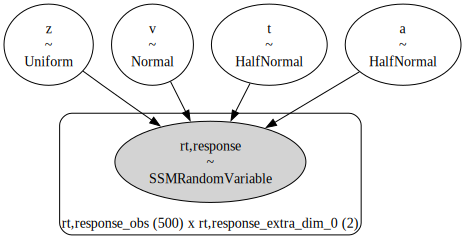

In [12]:
simple_ddm_model.graph()

This is the simplest model we can build. We have our basic parameters (unobserved, white node), and our observed reaction times and choices (`SSMRandomVariable`, grey node).

The `graph()` function becomes a lot more interesting for more complicated models!

### Sample from the Model

We can now call the `.sample()` function, to get posterior samples. The main arguments you may want to change are listed in the function call below. 

Importantly, multiple backends are possible. We choose the `nuts_numpyro` backend below,
which in turn compiles the model to a [`JAX`](https://github.com/google/jax) function.

In [13]:
infer_data_simple_ddm_model = simple_ddm_model.sample(
    sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
    cores=1,  # how many cores to use
    chains=2,  # how many chains to run
    draws=500,  # number of draws from the markov chain
    tune=1000,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
)  # mp_ctx="forkserver")

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/pymc/sampling_jax.py:19: DeprecationWarning: This module is deprecated, use pymc.sampling.jax
  warnings.warn("This module is deprecated, use pymc.sampling.jax", DeprecationWarning)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configurati

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/numpyro/util.py:227: DeprecationWarning: The host_callback APIs are deprecated as of March 20, 2024. The functionality is subsumed by the new JAX external callbacks. See https://jax.readthedocs.io/en/latest/notebooks/external_callbacks.html.
  lambda _: host_callback.id_tap(
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/ipykernel/iostream.py:154: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x2989c30e0>
  self._event_pipes[threadi

We sampled from the model, let's look at the output...

In [14]:
type(infer_data_simple_ddm_model)

arviz.data.inference_data.InferenceData

Errr... a closer look might be needed here!

### Inference Data / What gets returned from the sampler?

The sampler returns an [ArviZ](https://python.arviz.org/en/stable/) `InferenceData` object. 

To understand all the logic behind these objects and how they mesh with the Bayesian Workflow, we refer you to the [ArviZ Documentation](https://python.arviz.org/en/stable/getting_started/index.html). 

`InferenceData` is build on top of [xarrays](https://docs.xarray.dev/en/stable/index.html). The [xarray documentation](https://docs.xarray.dev/en/stable/index.html) will help you understand in more detail how to manipulate these objects.

But let's take a quick high-level look to understand roughly what we are dealing with here!

In [15]:
infer_data_simple_ddm_model

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

We see that in our case, `infer_data_simple_ddm_model` contains four basic types of data (note: this is extensible!)

- `posterior`
- `log_likelihood`
- `sample_stats`
- `observed_data`

The `posterior` object contains our traces for each of the parameters in the model. The `log_likelihood` field contains the trial wise log-likelihoods for each sample from the posterior. The `sample_stats` field contains information about the sampler run. This can be important for chain diagnostics, but we will not dwell on this here. Finally we retreive our `observed_data`.


### Basic Manipulation

#### Accessing groups and variables

In [16]:
infer_data_simple_ddm_model.posterior

<xarray.Dataset> Size: 24kB
Dimensions:          (chain: 2, draw: 500, rt,response_obs: 500)
Coordinates:
  * chain            (chain) int64 16B 0 1
  * draw             (draw) int64 4kB 0 1 2 3 4 5 6 ... 494 495 496 497 498 499
  * rt,response_obs  (rt,response_obs) int64 4kB 0 1 2 3 4 ... 496 497 498 499
Data variables:
    a                (chain, draw) float32 4kB 1.467 1.499 1.482 ... 1.423 1.547
    t                (chain, draw) float32 4kB 0.1697 0.1061 ... 0.1427 0.07929
    v                (chain, draw) float32 4kB 0.268 0.2974 ... 0.2563 0.2152
    z                (chain, draw) float32 4kB 0.516 0.5173 ... 0.5314 0.5222
Attributes:
    created_at:                  2024-07-09T05:02:15.546639+00:00
    arviz_version:               0.18.0
    modeling_interface:          bambi
    modeling_interface_version:  0.13.0

In [107]:
infer_data_simple_ddm_model.posterior.a.head()

<xarray.DataArray 'a' (chain: 2, draw: 5)> Size: 40B
array([[1.4674785, 1.4985443, 1.4818615, 1.4648522, 1.4546331],
       [1.4934804, 1.5192188, 1.4122267, 1.4612297, 1.436843 ]],
      dtype=float32)
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 40B 0 1 2 3 4

In [106]:
infer_data_simple_ddm_model.posterior.a.head()

<xarray.DataArray 'a' (chain: 2, draw: 5)> Size: 40B
array([[1.4674785, 1.4985443, 1.4818615, 1.4648522, 1.4546331],
       [1.4934804, 1.5192188, 1.4122267, 1.4612297, 1.436843 ]],
      dtype=float32)
Coordinates:
  * chain    (chain) int64 16B 0 1
  * draw     (draw) int64 40B 0 1 2 3 4

To simply access the underlying data as a `numpy.ndarray`, we can use `.values` (as e.g. when using `pandas.DataFrame` objects). 

In [113]:
type(infer_data_simple_ddm_model.posterior.a.values)

numpy.ndarray

#### Combine `chain` and `draw` dimension

When operating directly on the `xarray`, you will often find it useful to collapse the `chain` and `draw` coordinates into a single coordinate.
**Arviz** makes this easy via the `extract` method.

In [19]:
idata_extracted = az.extract(infer_data_simple_ddm_model)
idata_extracted

<xarray.Dataset> Size: 44kB
Dimensions:          (sample: 1000, rt,response_obs: 500)
Coordinates:
  * rt,response_obs  (rt,response_obs) int64 4kB 0 1 2 3 4 ... 496 497 498 499
  * sample           (sample) object 8kB MultiIndex
  * chain            (sample) int64 8kB 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1
  * draw             (sample) int64 8kB 0 1 2 3 4 5 ... 494 495 496 497 498 499
Data variables:
    a                (sample) float32 4kB 1.467 1.499 1.482 ... 1.423 1.547
    t                (sample) float32 4kB 0.1697 0.1061 ... 0.1427 0.07929
    v                (sample) float32 4kB 0.268 0.2974 0.2263 ... 0.2563 0.2152
    z                (sample) float32 4kB 0.516 0.5173 0.5078 ... 0.5314 0.5222
Attributes:
    created_at:                  2024-07-09T05:02:15.546639+00:00
    arviz_version:               0.18.0
    modeling_interface:          bambi
    modeling_interface_version:  0.13.0

Since *Arviz* really just calls the `.stack()` method from *xarray*, here the corresponding example using the lower level `xarray` interface.

In [20]:
infer_data_simple_ddm_model.posterior.stack(sample=('chain', 'draw'))

<xarray.Dataset> Size: 44kB
Dimensions:          (sample: 1000, rt,response_obs: 500)
Coordinates:
  * rt,response_obs  (rt,response_obs) int64 4kB 0 1 2 3 4 ... 496 497 498 499
  * sample           (sample) object 8kB MultiIndex
  * chain            (sample) int64 8kB 0 0 0 0 0 0 0 0 0 ... 1 1 1 1 1 1 1 1 1
  * draw             (sample) int64 8kB 0 1 2 3 4 5 ... 494 495 496 497 498 499
Data variables:
    a                (sample) float32 4kB 1.467 1.499 1.482 ... 1.423 1.547
    t                (sample) float32 4kB 0.1697 0.1061 ... 0.1427 0.07929
    v                (sample) float32 4kB 0.268 0.2974 0.2263 ... 0.2563 0.2152
    z                (sample) float32 4kB 0.516 0.5173 0.5078 ... 0.5314 0.5222
Attributes:
    created_at:                  2024-07-09T05:02:15.546639+00:00
    arviz_version:               0.18.0
    modeling_interface:          bambi
    modeling_interface_version:  0.13.0

#### Compute Quantities

##### Example: Mean and Covariance of Posterior Parameters

As a simple example, let us calculate the covariance matrix for our posterior samples.

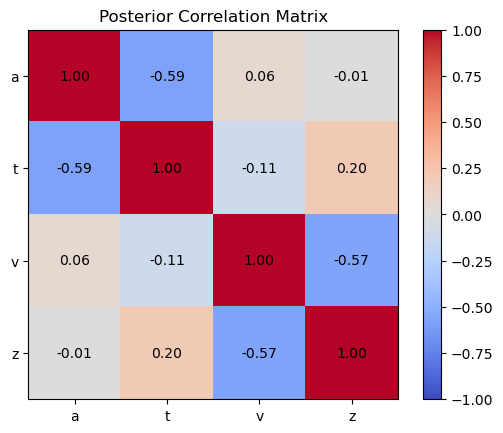

In [21]:
# Calculate the correlation matrix
posterior_correlation_matrix = np.corrcoef(np.stack([idata_extracted[var_].values for var_ in idata_extracted.data_vars.variables]))
num_vars = posterior_correlation_matrix.shape[0]

# Make heatmap
fig, ax = plt.subplots(1,1)
cax = ax.imshow(posterior_correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax, ax=ax)
ax.set_title("Posterior Correlation Matrix")

# Add ticks
ax.set_xticks(range(posterior_correlation_matrix.shape[0]))
ax.set_xticklabels([var_ for var_ in idata_extracted.data_vars.variables])
ax.set_yticks(range(posterior_correlation_matrix.shape[0]))
ax.set_yticklabels([var_ for var_ in idata_extracted.data_vars.variables])

# Annotate heatmap
for i in range(num_vars):
    for j in range(num_vars):
        ax.text(j, i, f'{posterior_correlation_matrix[i, j]:.2f}', ha='center', va='center', color='black')

plt.show()

### Making use of ArviZ

Working with the `InferenceData` directly, is very helpful if you want to include custom computations into your workflow. 
For a basic Bayesian Workflow however, you will often find that standard functionality available through [ArviZ](https://python.arviz.org/en/stable/)
suffices.

Below we provide a few examples of useful **Arviz** outputs, which come handy for analyzing your traces (MCMC samples).

#### Summary table

Let's take a look at a summary table for our posterior. 

In [22]:
az.summary(infer_data_simple_ddm_model)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a  1.479  0.036   1.411    1.548      0.001    0.001     746.0     565.0   
t  0.117  0.031   0.057    0.173      0.001    0.001     657.0     525.0   
v  0.232  0.040   0.163    0.310      0.002    0.001     609.0     743.0   
z  0.520  0.016   0.490    0.550      0.001    0.000     564.0     741.0   

   r_hat  
a   1.00  
t   1.01  
v   1.00  
z   1.00

In [23]:
rv_list = [my_free_rv for my_free_rv in simple_ddm_model.pymc_model.free_RVs]

In [24]:
az.summary(infer_data_simple_ddm_model, 
           var_names = [var_name.name for var_name in simple_ddm_model.pymc_model.free_RVs])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
z  0.520  0.016   0.490    0.550      0.001    0.000     564.0     741.0   
t  0.117  0.031   0.057    0.173      0.001    0.001     657.0     525.0   
a  1.479  0.036   1.411    1.548      0.001    0.001     746.0     565.0   
v  0.232  0.040   0.163    0.310      0.002    0.001     609.0     743.0   

   r_hat  
z   1.00  
t   1.01  
a   1.00  
v   1.00

This table returns the parameter-wise mean of our posterior and a few extra statistics.

Of these extra statistics, the one-stop shop for flagging convergence issues is the `r_hat` value, which 
is reported in the right-most column. 

To navigate this statistic, here is a rule of thumb widely used in applied Bayesian statistics.

If you find an `r_hat` value `> 1.01`, it warrants investigation.

#### Trace plot

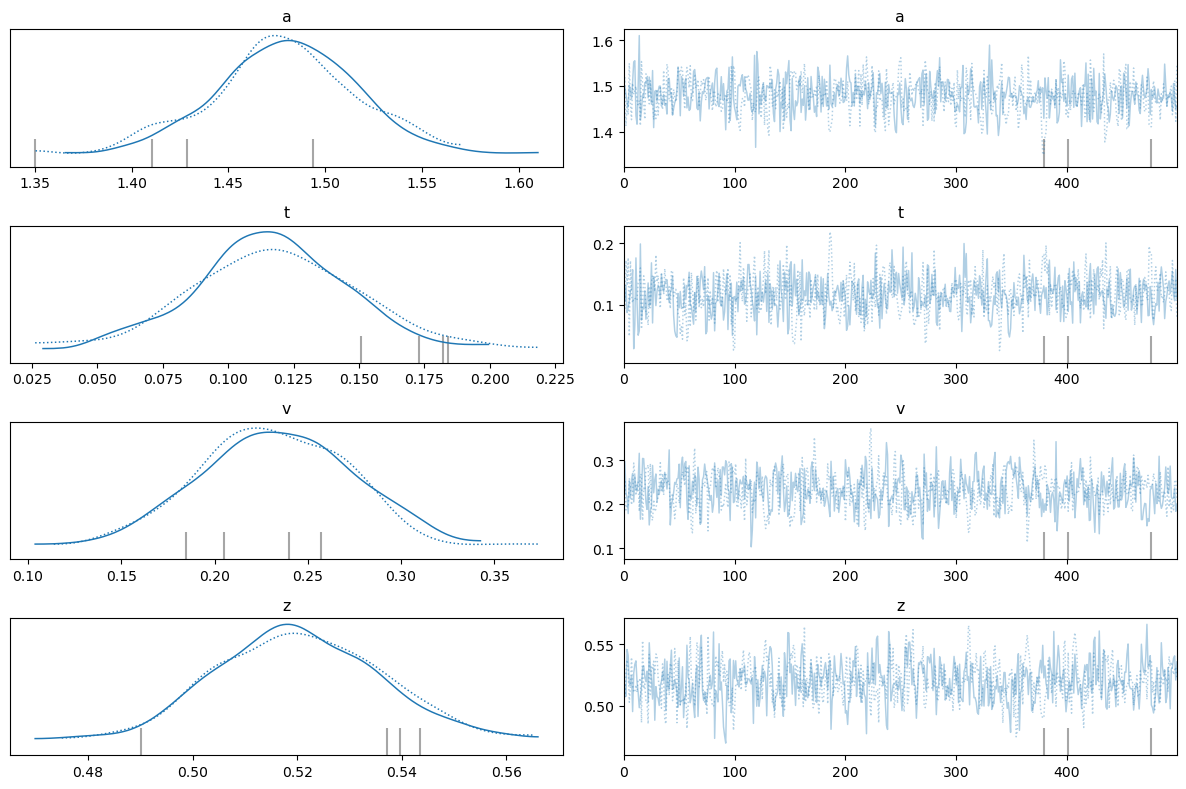

In [25]:
az.plot_trace(
    infer_data_simple_ddm_model,  # we exclude the log_likelihood traces here
)
plt.tight_layout()

The `.sample()` function also sets a `trace` attribute, on our `hssm` class, so instead, we could call the plot like so:

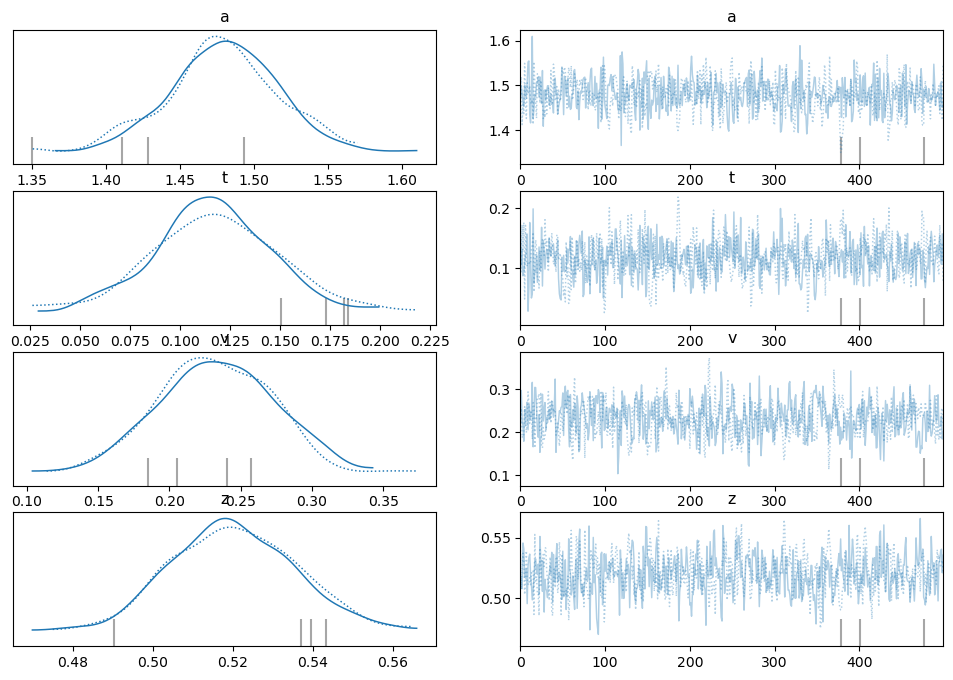

In [26]:
az.plot_trace(simple_ddm_model.traces);

In this tutorial we are most often going to use the latter way of accessing the traces, but there is no preferred option. 

Let's look at a few more plots.

#### Forest Plot

The forest plot is commonly used for a quick visual check of the marginal posteriors. It is very effective for intuitive communication of results.

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

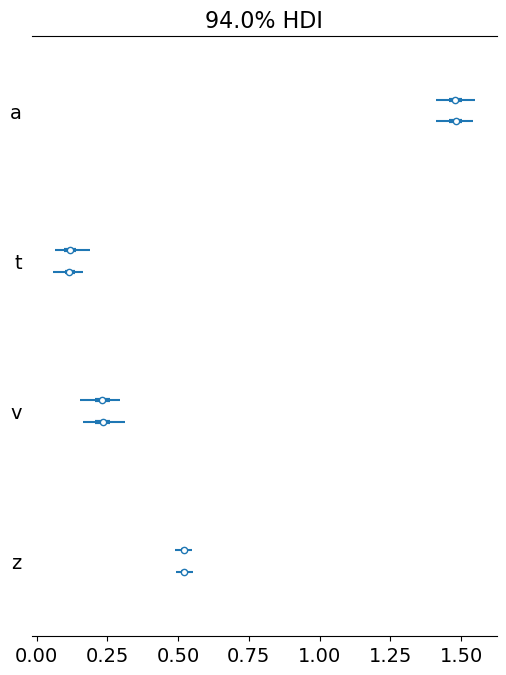

In [27]:
az.plot_forest(simple_ddm_model.traces)

##### Combining Chains
By default, chains are separated out into *separate caterpillars*, however
sometimes, especially if you are looking at a forest plot which includes many posterior parameters at once, you want to declutter and collapse the chains into single caterpillars.
In this case you can `combine` chains instead.

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

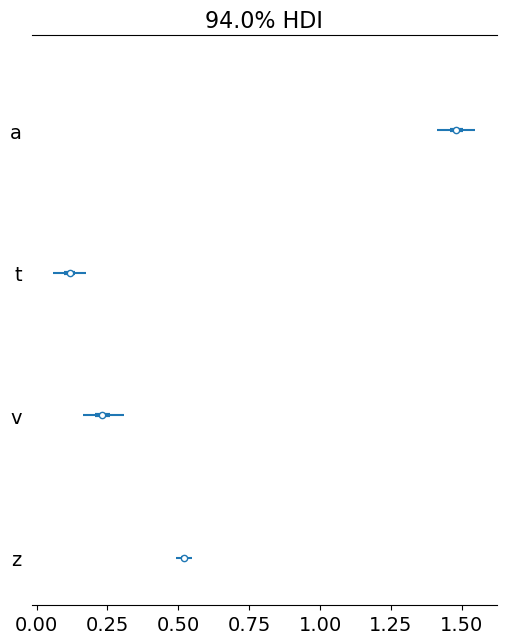

In [28]:
az.plot_forest(simple_ddm_model.traces, combined=True)

#### Basic Marginal Posterior Plot

Another way to view the marginal posteriors is provided by the `plot_posterior()` function. It shows the mean and by default the $94\%$ HDIs.

array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 't'}>,
       <Axes: title={'center': 'v'}>, <Axes: title={'center': 'z'}>],
      dtype=object)

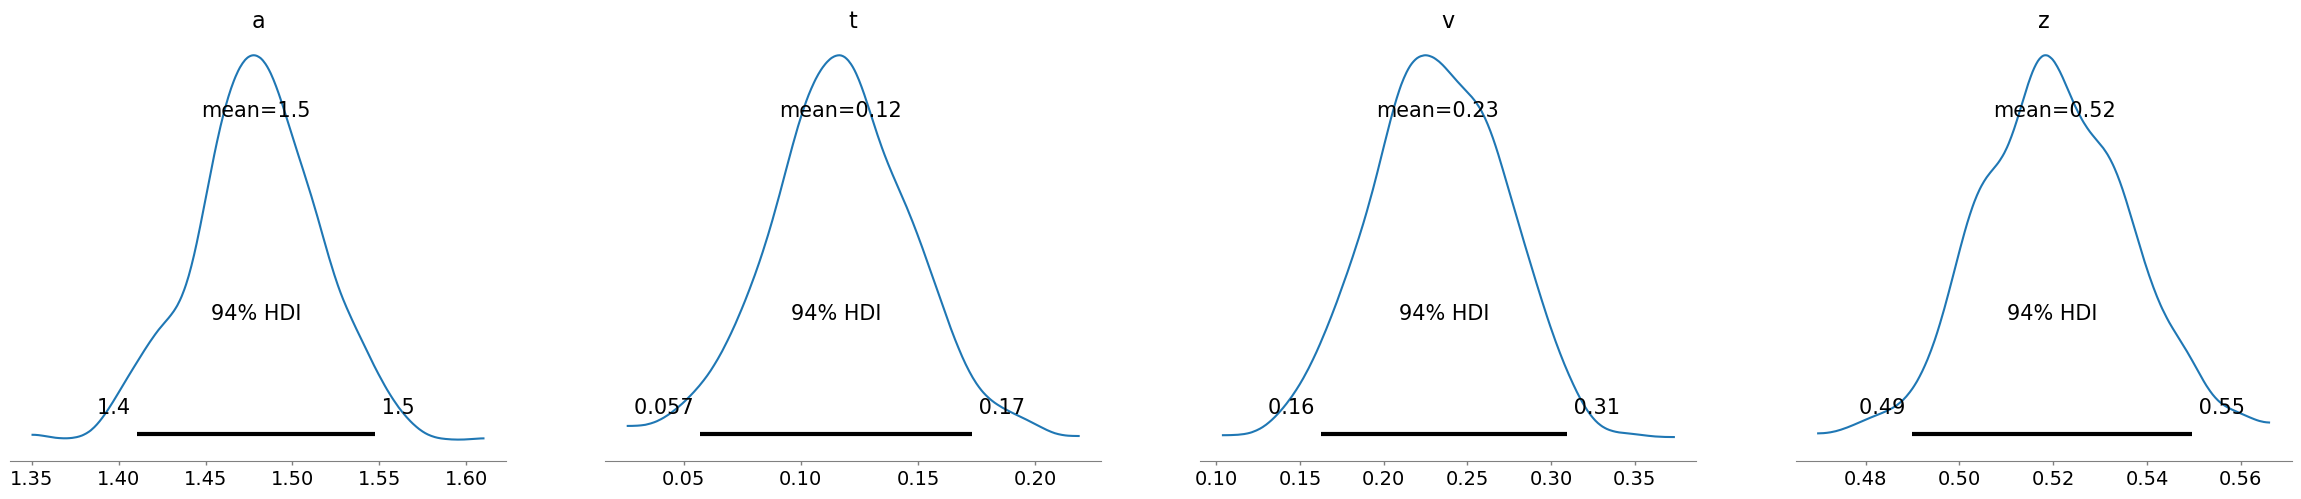

In [29]:
az.plot_posterior(simple_ddm_model.traces)

Especially for parameter recovery studies, you may want to include **reference values** for the parameters of interest. 

You can do so using the `ref_val` argument. See the example below:

array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 't'}>,
       <Axes: title={'center': 'v'}>, <Axes: title={'center': 'z'}>],
      dtype=object)

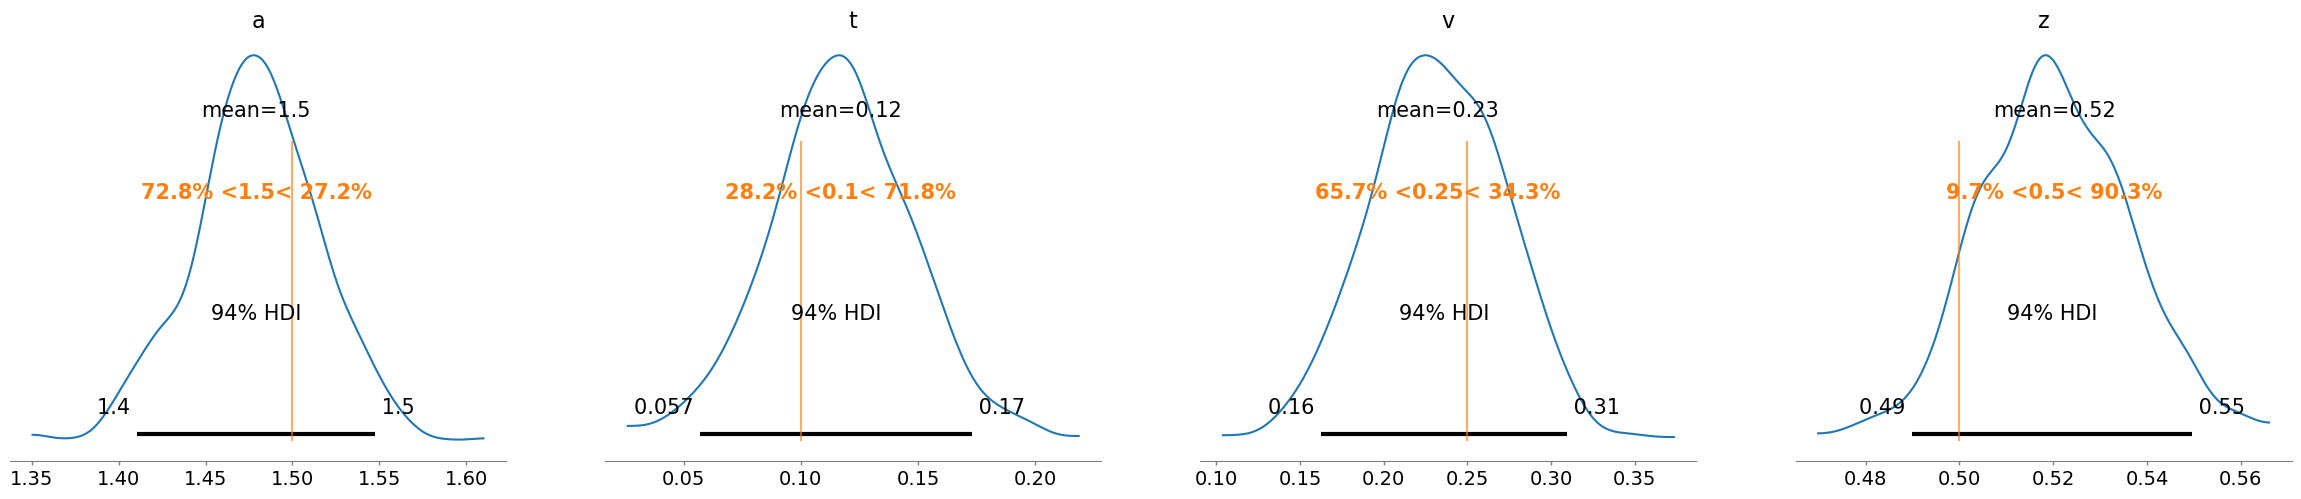

In [30]:
ref_val_dict = dict(v = 0.25, a = 1.5, z = 0.5, t = 0.1)
az.plot_posterior(simple_ddm_model.traces, 
                  ref_val = [ref_val_dict[var_name] for var_name in simple_ddm_model.traces.posterior.data_vars])

Since it is sometimes useful, especially for more complex cases, below an alternative approach in which we pass `ref_val` as a dictionary.


array([<Axes: title={'center': 'a'}>, <Axes: title={'center': 't'}>,
       <Axes: title={'center': 'v'}>, <Axes: title={'center': 'z'}>],
      dtype=object)

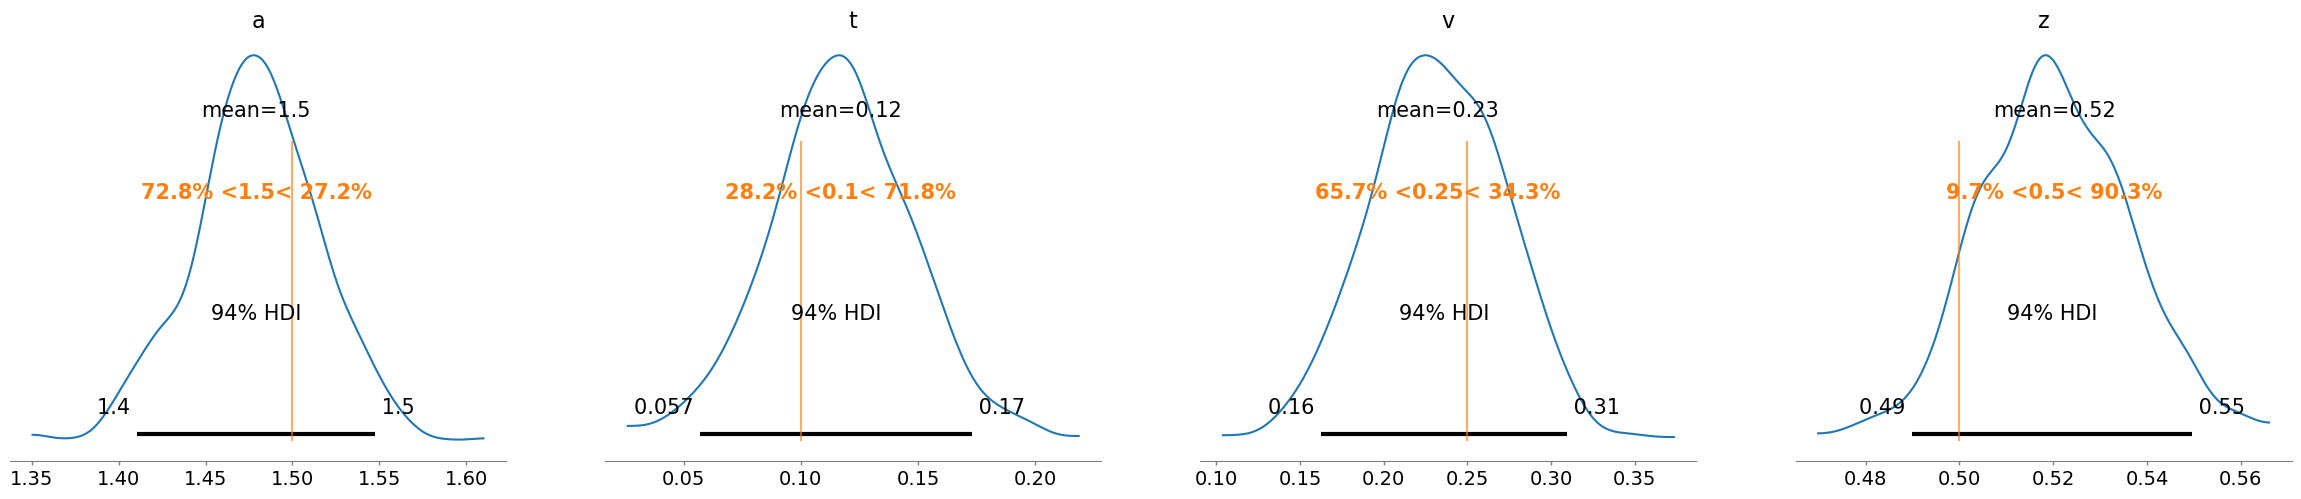

In [31]:
az.plot_posterior(simple_ddm_model.traces, ref_val = {'v': [{'ref_val': 0.25}],
                                                      'a': [{'ref_val': 1.5}],
                                                      'z': [{'ref_val': 0.5}],
                                                      't': [{'ref_val': 0.1}]})

#### Posterior Pair Plot

The posterior pair plot is useful to check for simple parameter tradeoffs that may emerge. In our `ddm` example, we see a little bit of a tradeoff between `a` and `t`, as well as between `v` and `z`, however nothing that would concern us with regards to samler issues. 

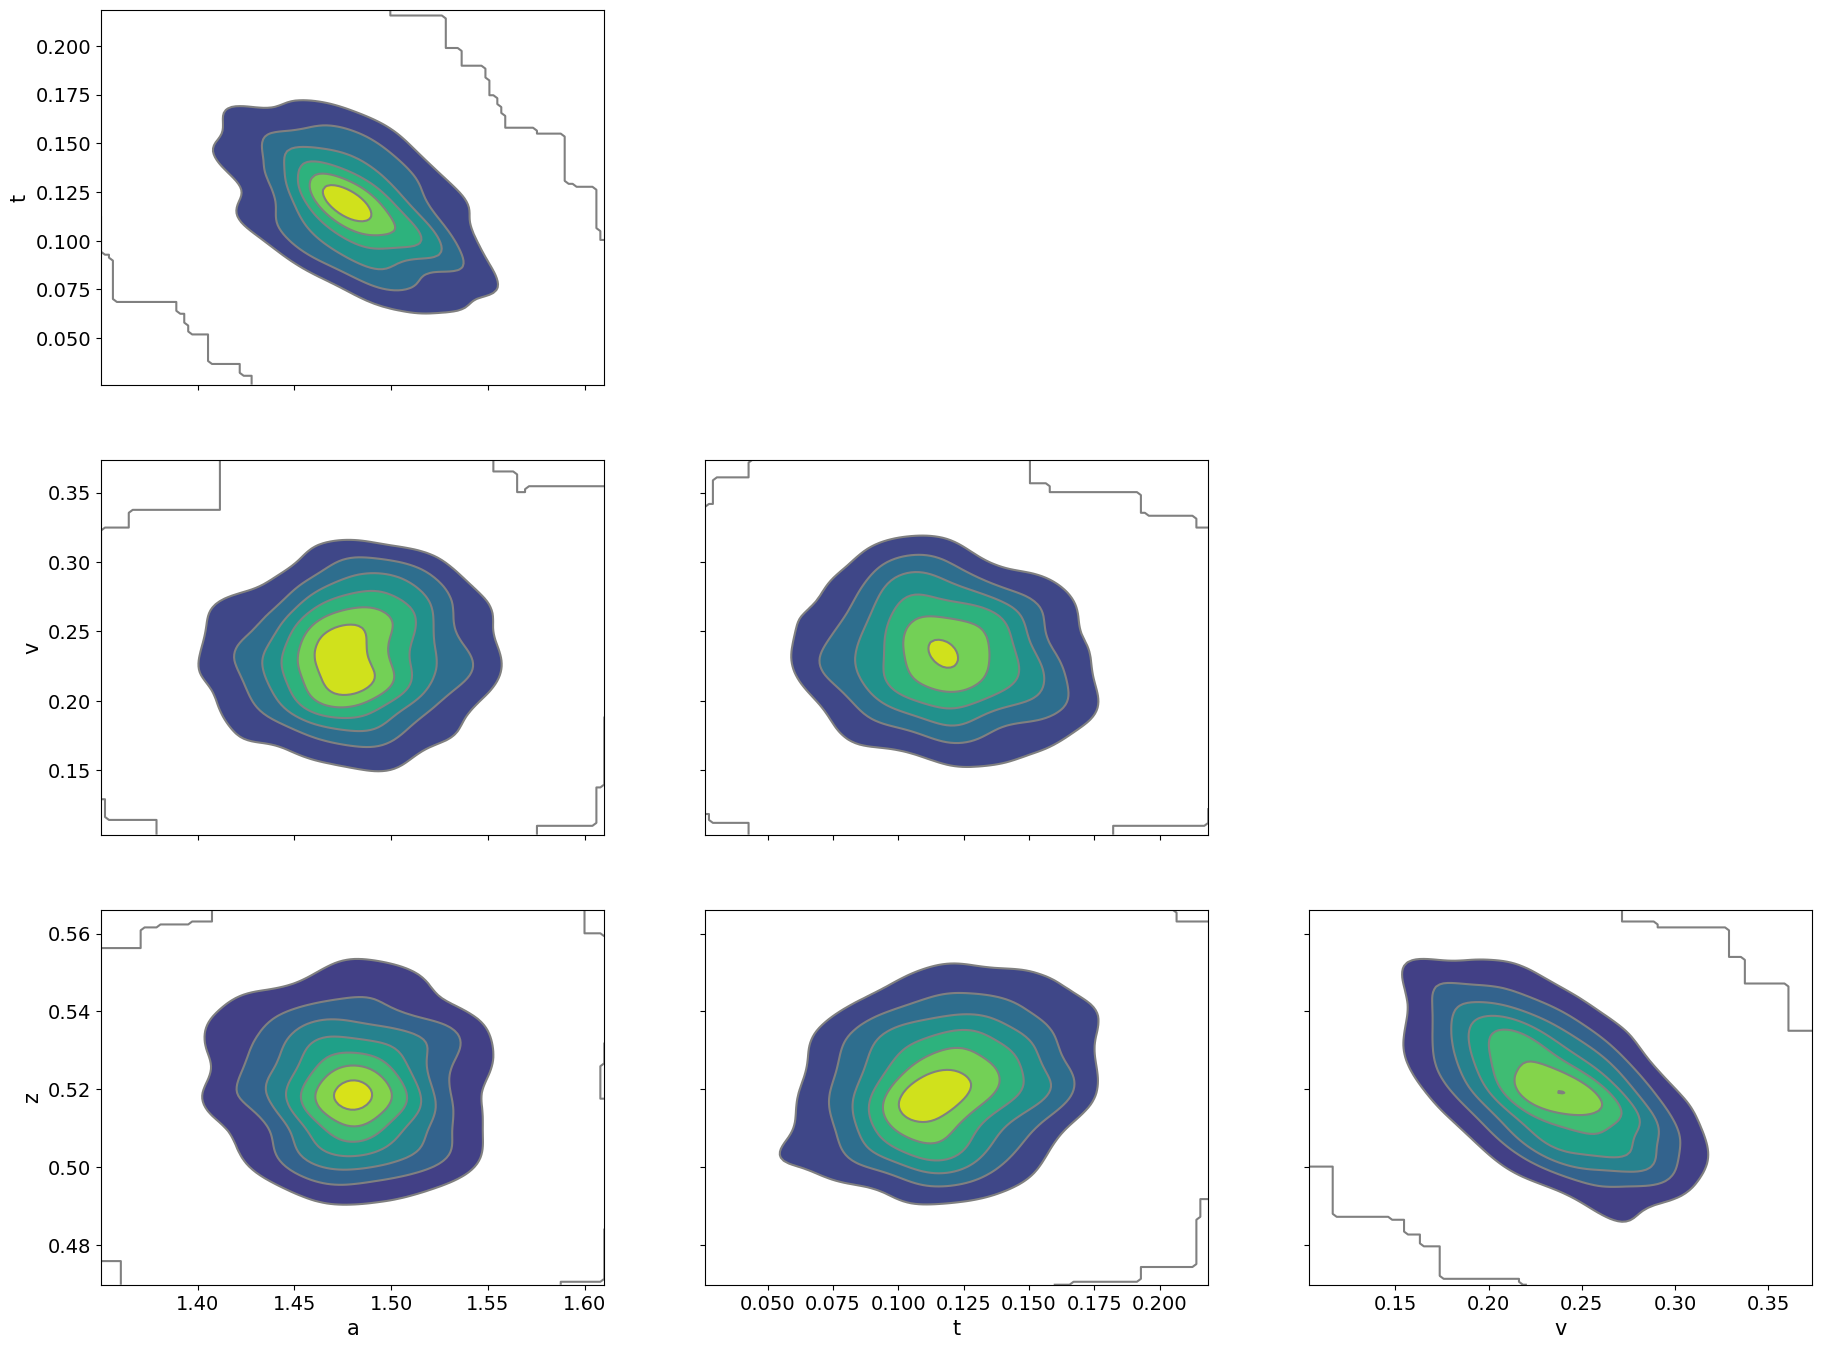

In [32]:
az.plot_pair(simple_ddm_model.traces, kind="kde");

The few plot we showed here are just the beginning: [ArviZ](https://python.arviz.org/en/stable/) has a much broader spectrum of graphs and other convenience function available. Just check the [documentation](https://python.arviz.org/en/stable/). 

## HSSM Model based on LAN likelihood

With HSSM you can switch between pre-supplied models with a simple change of argument. The type of likelihood that will be accessed might change in the background for you. 

Here we see an example in which the underlying likelihood is now a [LAN](https://elifesciences.org/articles/65074).

We will talk more about different types of likelihood functions and backends later in the tutorial. For now just keep the following in mind:

There are three types of likelihoods

1. `analytic`
2. `approx_differentiable`
3. `blackbox`

To check which type is used in your HSSM model simple type:

In [33]:
simple_ddm_model.loglik_kind

'analytical'

Ah... we were using an `analytical` likelihood with the DDM model in the last section.
Now let's see something different!

### Simulating Angle Data

Again, let us simulate a simple dataset. This time we will use the `angle` model (passed via the `model` argument to the `simulator()` function). 


This model is distinguished from the basic `ddm` model by an additional `theta` parameter which specifies the angle with which the decision boundaries collapse over time.

<center> <img src="images/ANGLE_with_params_pic.png" height="400" width="400"> </center>

DDMs with collapsing bounds have been of significant interest in the theoretical literature, but applications were rare due to a lack of analytical likelihoods. HSSM facilitates inference with such models via the our `approx_differentiable` likelihoods. HSSM ships with a few predefined models based on [LANs](https://elifesciences.org/articles/65074), but really we don't want to overemphasize those. They reflect the research interest of our and adjacent labs to a great extend. 

Instead, we encourage the community to contribute to this model reservoir (more on this later). 

In [34]:
# Simulate angle data
dataset_angle = hssm.simulate_data(model = 'angle',
                                   theta = dict(v = 0.5, 
                                                a = 1.5, 
                                                z = 0.5,
                                                t = 0.2,
                                                theta = 0.2),
                                   size = 1000,
                                  )

We pass a single additional argument to our `HSSM` class and set `model='angle'`. 

In [35]:
model_angle = hssm.HSSM(data=dataset_angle, model="angle")

model_angle

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/bambi/priors/prior.py:56: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  f"{k}: {format_arg(v, 4)}" if not isinstance(v, type(self)) else f"{k}: {v}"


Hierarchical Sequential Sampling Model
Model: angle

Response variable: rt,response
Likelihood: approx_differentiable
Observations: 1000

Parameters:

v:
    Prior: Uniform(lower: -3.0, upper: 3.0)
    Explicit bounds: (-3.0, 3.0)

a:
    Prior: Uniform(lower: 0.30000001192092896, upper: 3.0)
    Explicit bounds: (0.3, 3.0)

z:
    Prior: Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)
    Explicit bounds: (0.1, 0.9)

t:
    Prior: Uniform(lower: 0.0010000000474974513, upper: 2.0)
    Explicit bounds: (0.001, 2.0)

theta:
    Prior: Uniform(lower: -0.10000000149011612, upper: 1.2999999523162842)
    Explicit bounds: (-0.1, 1.3)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)

The model graph now show us an additional parameter `theta`!

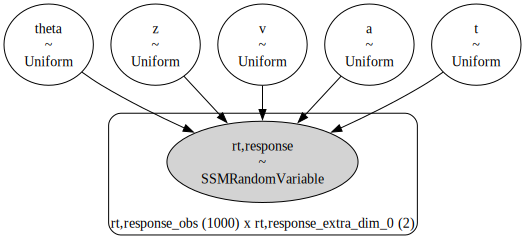

In [36]:
model_angle.graph()

Let's check the type of likelihood that is used under the hood ...

In [37]:
model_angle.loglik_kind

'approx_differentiable'

Ok so here we rely on a likelihood of the `approx_differentiable` kind. 

As discussed, with the initial set of pre-supplied likelihoods, this implies that we are using a [LAN](https://elifesciences.org/articles/65074) in the background.

In [38]:
jax.config.update("jax_enable_x64", False)
infer_data_angle = model_angle.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=2,
    draws=500,
    tune=500,
    idata_kwargs=dict(log_likelihood=False),  # no need to return likelihoods here
)

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/numpyro/util.py:227: DeprecationWarning: The host_callback APIs are deprecated as of March 20, 2024. The functionality is subsumed by the new JAX external callbacks. See https://jax.readthedocs.io/en/latest/notebooks/external_callbacks.html.
  lambda _: host_callback.id_tap(
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/ipykernel/iostream.py:154: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x2989c3770>
  self._event_pipes[threadi

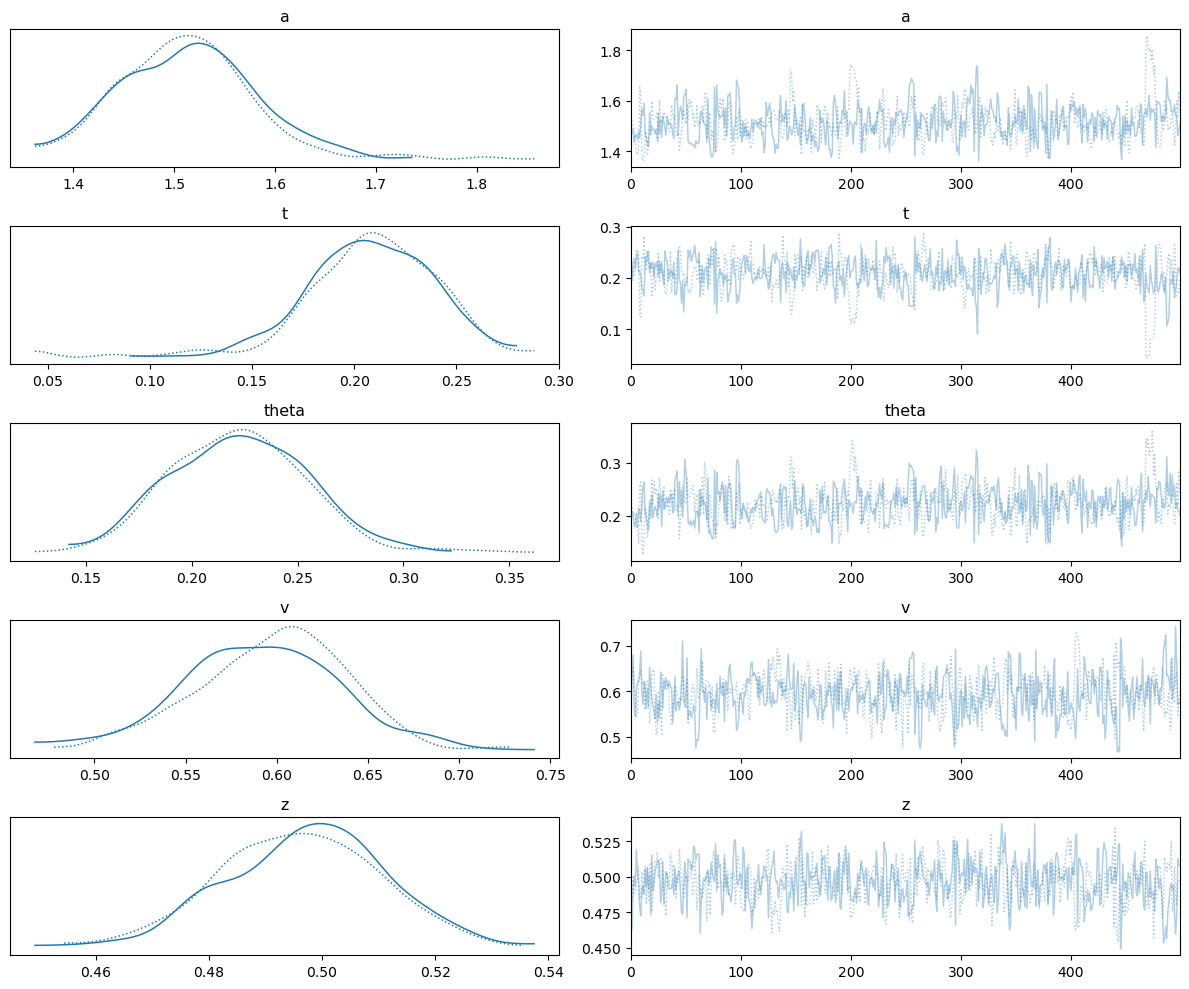

In [39]:
az.plot_trace(model_angle.traces)
plt.tight_layout()

## Choosing Priors

HSSM allows you to specify priors quite freely. If you used HDDM previously, you may feel relieved to read that your hands are now untied!


<center><img src="https://media.giphy.com/media/99uUPYHtmaJS8/giphy.gif" style="margin:auto" height="400" width="400"/></center>

With HSSM we have multiple routes to priors. But let's first consider a special case:

### Fixing a parameter to a given value

Assume that instead of fitting all parameters of the DDM, 

<center> <img src="images/DDM_with_params_pic.png" height="400" width="400"> </center> 

we instead want to fit only the `v` (drift) parameter, setting all other parameters to fixed scalar values.

<center> <img src="images/DDM_only_v_pic.png" height="400" width="400"> </center> 

HSSM makes this extremely easy!

In [40]:
ddm_model_only_v = hssm.HSSM(data=dataset, model="ddm", a=1.5, t=0.2, z=0.5)

Since we fix all but one parameter, we therefore estimate only one parameter. This should be reflected in our model graph, where we expect only one free random variable `v`:

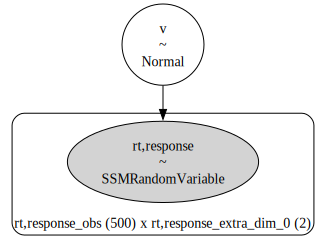

In [41]:
ddm_model_only_v.graph()

In [42]:
ddm_model_only_v.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=2,
    draws=500,
    tune=500,
    idata_kwargs=dict(log_likelihood=False),  # no need to return likelihoods here
)

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/numpyro/util.py:227: DeprecationWarning: The host_callback APIs are deprecated as of March 20, 2024. The functionality is subsumed by the new JAX external callbacks. See https://jax.readthedocs.io/en/latest/notebooks/external_callbacks.html.
  lambda _: host_callback.id_tap(
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/ipykernel/iostream.py:154: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x2a8516f90>
  self._event_pipes[threadi

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

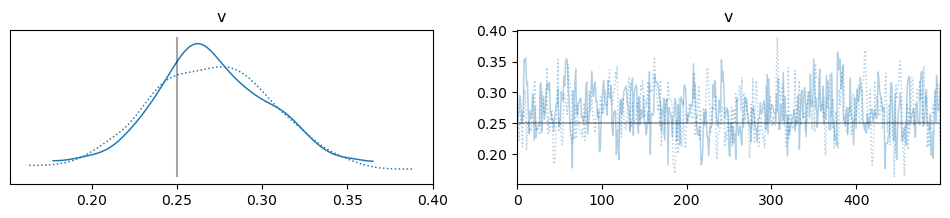

In [43]:
az.plot_trace(ddm_model_only_v.traces.posterior, lines = [('v', {}, 0.25)]);

Instead of the trace on the right, a useful alternative / complement is the **rank plot**.
As a rule of thumb, if the rank plots within chains look *uniformly distributed*, then our chains generally exhibit *good mixing*.

array([[<Axes: title={'center': 'v'}>,
        <Axes: title={'center': 'v'}, xlabel='Rank (all chains)', ylabel='Chain'>]],
      dtype=object)

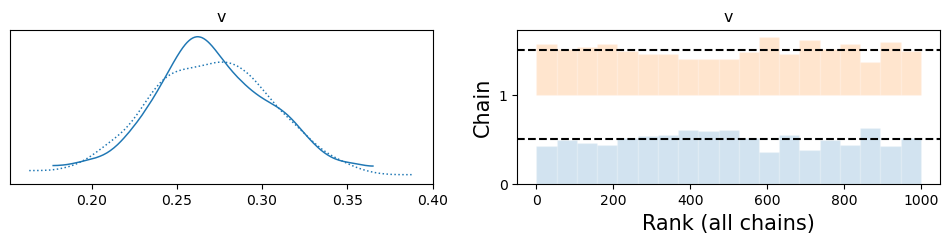

In [44]:
az.plot_trace(ddm_model_only_v.traces, kind = 'rank_bars')

##### AF:TODO

`lines` argument doesn't work properly with the rank plots! Should make arviz issue!

### Named priors

We can choose any [PyMC](https://www.pymc.io/welcome.html) `Distribution` to specify a prior for a given parameter. 

Even better, if natural *parameter bounds* are provided, HSSM *automatically truncates the prior distribution* so that it respect these bounds. 

Below is an example in which we specify a *Normal* prior on the `v` parameter of the DDM. 

We choose a *ridiculously low* $\sigma$ value, to illustrate it's regularizing effect on the parameter (just so we see a difference and you are convinced that something changed). 

In [45]:
model_normal = hssm.HSSM(
    data=dataset,
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0, "sigma": 0.01},
        }
    ],
)

In [46]:
model_normal

/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/src/hssm/prior.py:78: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  f"{k}: {format_arg(v, 4)}"
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/bambi/priors/prior.py:56: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  f"{k}: {format_arg(v, 4)}" if not isinstance(v, type(self)) else f"{k}: {v}"


Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 500

Parameters:

v:
    Prior: Normal(mu: 0.0, sigma: 0.009999999776482582)
    Explicit bounds: (-inf, inf)

a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)

##### AF:TODO

Figure out if we can naively drop usage of `round_`!

In [47]:
infer_data_normal = model_normal.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=2,
    draws=500,
    tune=500,
    idata_kwargs=dict(log_likelihood=False),  # no need to return likelihoods here
)

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_met

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/numpyro/util.py:227: DeprecationWarning: The host_callback APIs are deprecated as of March 20, 2024. The functionality is subsumed by the new JAX external callbacks. See https://jax.readthedocs.io/en/latest/notebooks/external_callbacks.html.
  lambda _: host_callback.id_tap(
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/ipykernel/iostream.py:154: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x2989680c0>
  self._event_pipes[threadi

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>]],
      dtype=object)

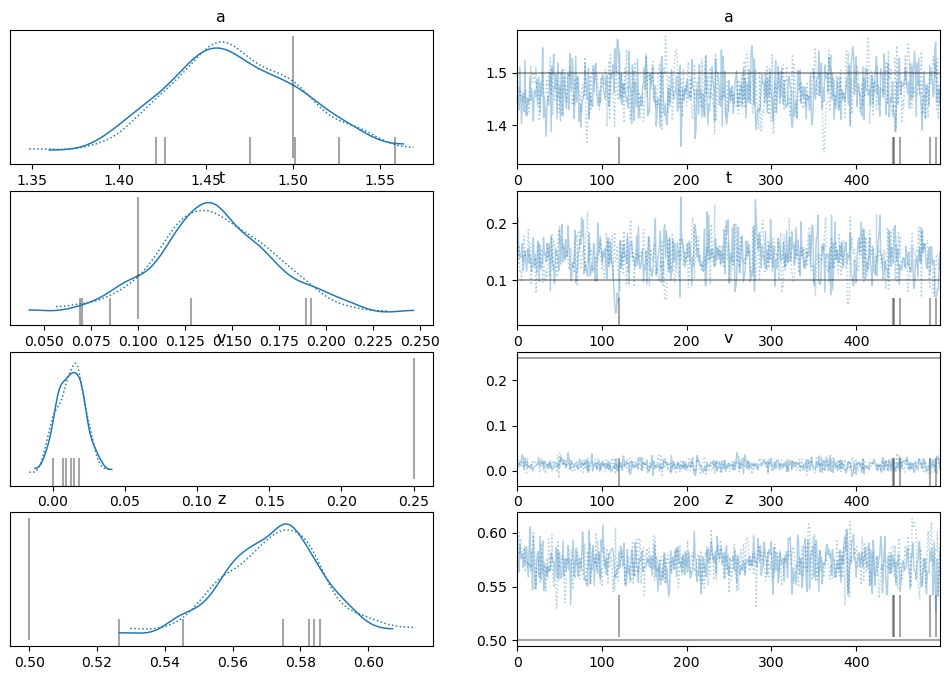

In [48]:
az.plot_trace(model_normal.traces, lines = [('v', {}, 0.25), 
                                            ('a', {}, 1.5),
                                            ('t', {}, 0.1),
                                            ('z', {}, 0.5)])

Observe how we reused our previous dataset with underlying parameters 

- `v = 0.5`
- `a = 1.5`
- `z = 0.5`
- `t = 0.2`

In contrast to our previous sampler round, in which we used Uniform priors, here the `v` estimate is shrunk severley towared $0$ and the `t` and `z` parameter estimates are very biased to make up for this distortion.

## HSSM Model with Regression


<center> <img src="images/bambi.png" height="200" width="200"> </center>

Crucial to the scope of HSSM is the ability to link parameters with trial-by-trial covariates via (hierarchical, but more on this later) general linear models. 
 
In this section we explore how HSSM deals with these models. No big surprise here... it's simple!

### Case 1: One parameter is a Regression Target 

#### Simulating Data

Let's first simulate some data, where the trial-by-trial parameters of the `v` parameter in our model are driven by a simple linear regression model.


The regression model is driven by two (random) covariates `x` and `y`, respectively with coefficients of $0.8$ and $0.3$ which are also simulated below.
We set the intercept to $0.3$.

The rest of the parameters are fixed to single values as before.

In [49]:
# Set up trial by trial parameters
v_intercept = 0.3
x = np.random.uniform(-1, 1, size=1000)
v_x = 0.8
y = np.random.uniform(-1, 1, size=1000)
v_y = 0.3
v_reg_v = v_intercept + (v_x * x) + (v_y * y)

# rest
a_reg_v = 1.5
z_reg_v = 0.5
t_reg_v = 0.1

# base dataset
dataset_reg_v = hssm.simulate_data(model = 'ddm',
                                   theta = dict(v = v_reg_v,
                                                a = a_reg_v,
                                                z = z_reg_v,
                                                t = t_reg_v),
                                   size = 1)

# Adding covariates into the datsaframe
dataset_reg_v['x'] = x
dataset_reg_v['y'] = y

#### Basic Model

We now create the `HSSM` model. 

Notice how we set the `include` argument. The include argument expects a list of dictionaries, one dictionary for each parameter to be specified via a regression model. 

Four `keys` are expected to be set:

- The `name` of the parameter, 
- Potentially a `prior` for each of the regression level parameters ($\beta$'s), 
- The regression `formula` 
- A `link` function. 

The regression formula follows the syntax in the [formulae](https://pypi.org/project/formulae/) python package (as used by the [Bambi](https://bambinos.github.io/bambi/) package for building Bayesian Hierarchical Regression Models. 

[Bambi](https://bambinos.github.io/bambi/) forms the main model-construction backend of HSSM.

In [50]:
model_reg_v_simple = hssm.HSSM(
    data = dataset_reg_v,
    include = [{"name": "v",
                "formula": "v ~ 1 + x + y"}])

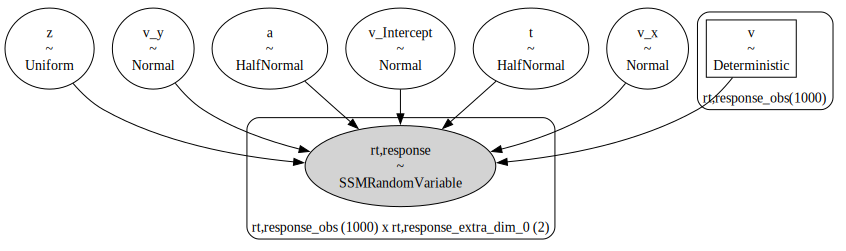

In [51]:
model_reg_v_simple.graph()

In [52]:
print(model_reg_v_simple)

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Formula: v ~ 1 + x + y
    Priors:
        v_Intercept ~ Normal(mu: 2.0, sigma: 3.0)
        v_x ~ Normal(mu: 0.0, sigma: 0.25)
        v_y ~ Normal(mu: 0.0, sigma: 0.25)
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)


/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/src/hssm/prior.py:78: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  f"{k}: {format_arg(v, 4)}"
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/bambi/priors/prior.py:56: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  f"{k}: {format_arg(v, 4)}" if not isinstance(v, type(self)) else f"{k}: {v}"


#### Custom Model

These were the defaults, with a little extra labor, we can e.g. customize the choice of priors for each parameter in the model.

In [53]:
model_reg_v = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
            "link": "identity",
        }
    ],
)

In [54]:
model_reg_v

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/bambi/priors/prior.py:56: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  f"{k}: {format_arg(v, 4)}" if not isinstance(v, type(self)) else f"{k}: {v}"
/Users/afengler/Library/CloudStorage/OneDrive-Personal/proj_hssm/HSSM/src/hssm/prior.py:78: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  f"{k}: {format_arg(v, 4)}"


Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Formula: v ~ 1 + x + y
    Priors:
        v_Intercept ~ Uniform(lower: -3.0, upper: 3.0)
        v_x ~ Uniform(lower: -1.0, upper: 1.0)
        v_y ~ Uniform(lower: -1.0, upper: 1.0)
    Link: identity
    Explicit bounds: (-inf, inf)

a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)

z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)

t:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)


Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)

Notice how `v` is now set as a regression.

In [55]:
infer_data_reg_v = model_reg_v.sample(
    sampler="nuts_numpyro", chains=1, cores=1, draws=500, tune=500
)

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_met

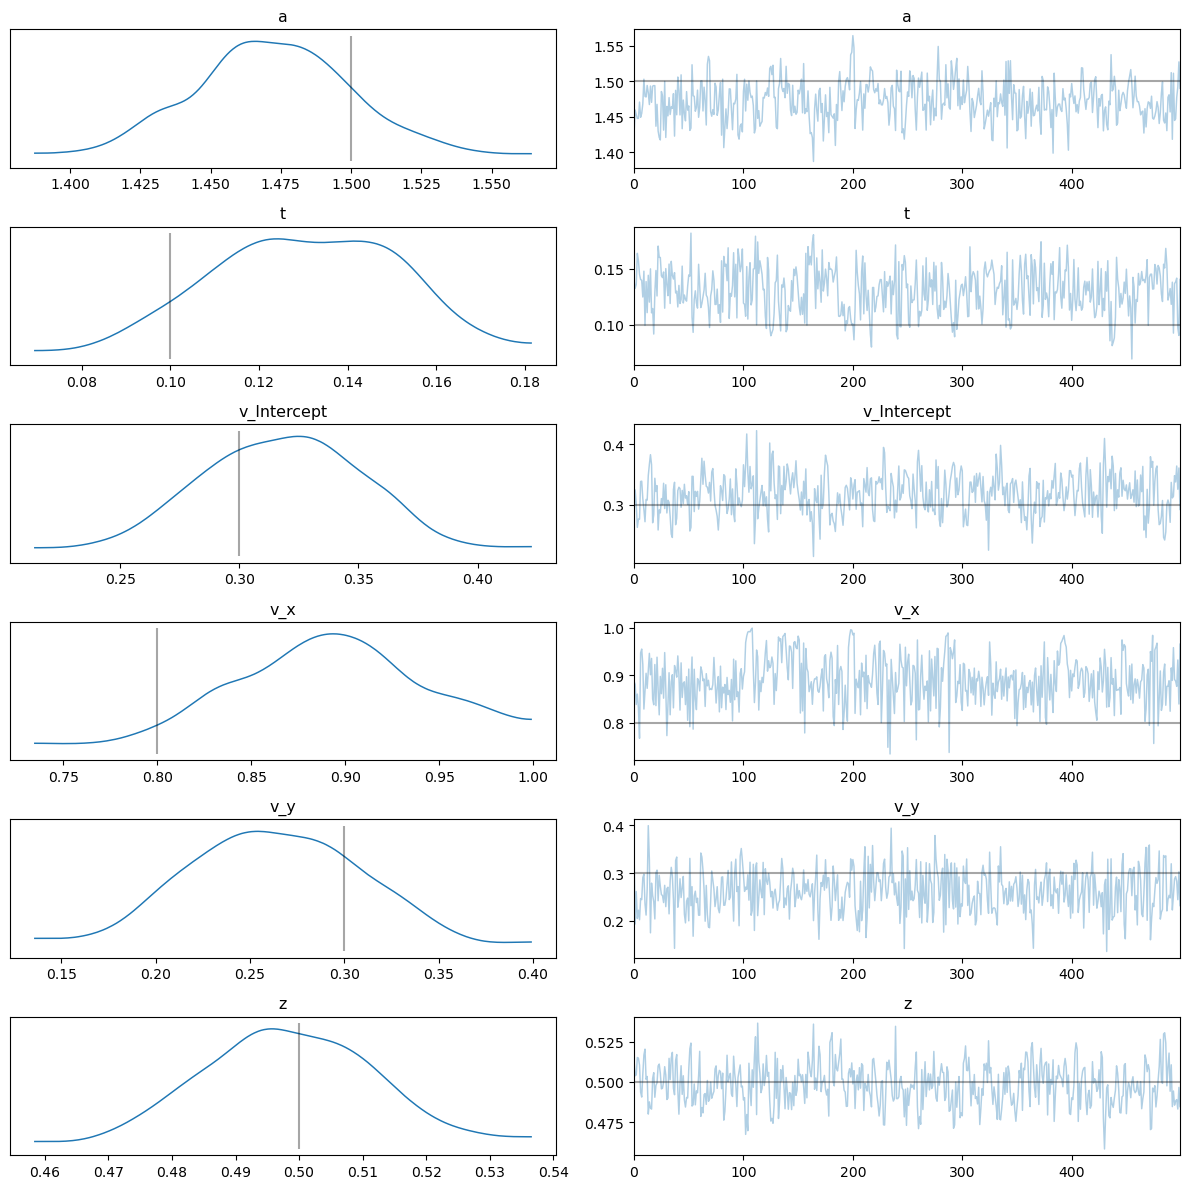

In [56]:
az.plot_trace(model_reg_v.traces, 
              var_names = ['~v'],
              lines = [('a', {}, a_reg_v), 
                       ('v_Intercept', {}, v_intercept), 
                       ('v_x', {}, v_x),
                       ('v_y', {}, v_y),
                       ('t', {}, t_reg_v),
                       ('z', {}, z_reg_v)])
plt.tight_layout()

In [57]:
# Looks like parameter recovery was successful
az.summary(model_reg_v.traces, var_names = ['~v'])

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a            1.472  0.028   1.426    1.529      0.002    0.001     187.0   
t            0.130  0.020   0.090    0.164      0.001    0.001     207.0   
v_Intercept  0.318  0.033   0.254    0.373      0.002    0.002     235.0   
v_x          0.891  0.050   0.802    0.984      0.004    0.003     171.0   
v_y          0.263  0.045   0.187    0.346      0.002    0.001     483.0   
z            0.498  0.013   0.473    0.520      0.001    0.001     234.0   

             ess_tail  r_hat  
a               278.0    NaN  
t               266.0    NaN  
v_Intercept     368.0    NaN  
v_x             134.0    NaN  
v_y             383.0    NaN  
z               296.0    NaN

### Case 2: One parameter is a Regression (LAN)

We can do the same thing with the `angle` model.

**Note**: 

Our dataset was generated from the basic DDM here, so since the DDM assumes stable bounds, we expect the `theta` (angle of linear collapse) parameter to be recovered as close to $0$.

In [58]:
model_reg_v_angle = hssm.HSSM(
    data=dataset_reg_v,
    model="angle",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    # "initval": 0   # optional --> set the initial value of the parameter (to e.g. avoid boundary violations at the intial sampling step)
                },
                "x": {
                    "name": "Uniform",
                    "lower": -1.0,
                    "upper": 1.0,
                },
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
            "link": "identity",
        }
    ],
)

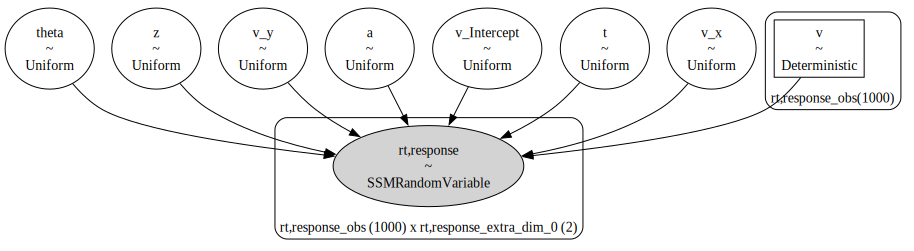

In [59]:
model_reg_v_angle.graph()

In [60]:
trace_reg_v_angle = model_reg_v_angle.sample(
    sampler="nuts_numpyro", chains=1, cores=1, draws=500, tune=500
)

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
sample: 100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:14<00:00, 66.80it/s, 7 steps of size 3.52e-01. acc. prob=0.94]
Only one chain was sampled, this makes it impossible to run some convergence checks


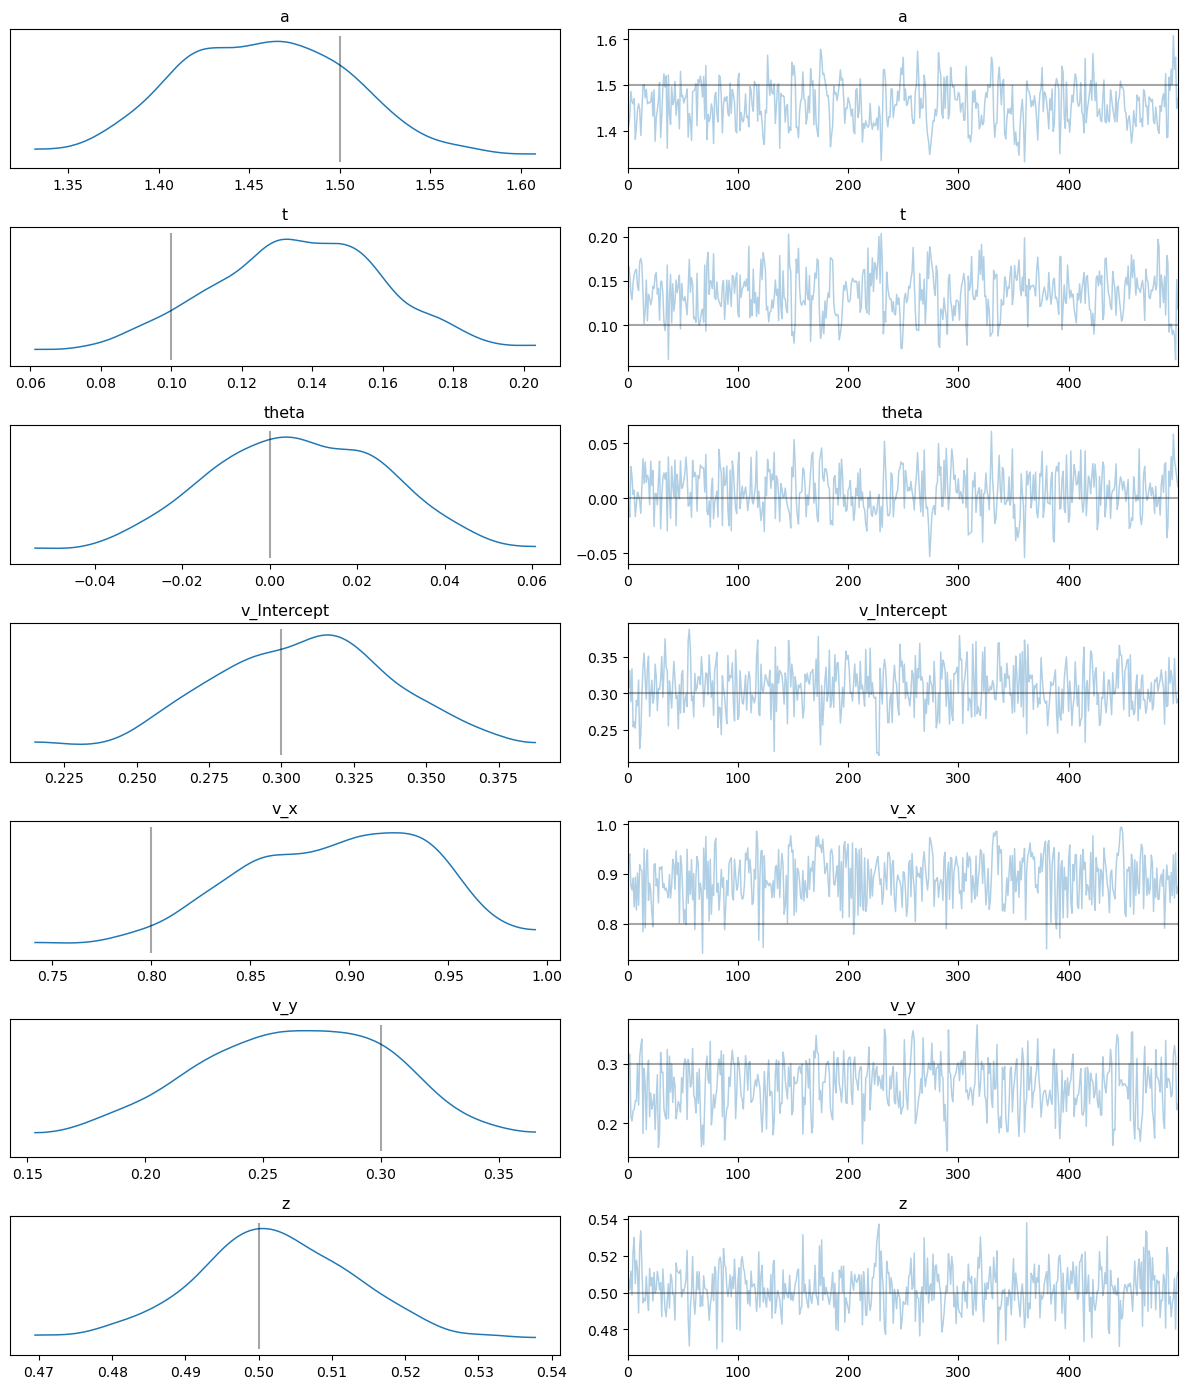

In [61]:
az.plot_trace(model_reg_v_angle.traces, 
              var_names = ['~v'],
              lines = [('a', {}, a_reg_v), 
                       ('v_Intercept', {}, v_intercept), 
                       ('v_x', {}, v_x),
                       ('v_y', {}, v_y),
                       ('t', {}, t_reg_v),
                       ('z', {}, z_reg_v),
                       ('theta', {}, 0)])
plt.tight_layout()

Great! `theta` is recovered correctly, on top of that, we have reasonable recovery for all other parameters!

### Case 3: Multiple Parameters are Regression Targets (LAN) 

Let's get a bit more ambitious. We may, for example, want to try a regression on a few of our basic model parameters at once. Below we show an example where we model both the `a` and the `v` parameters with a regression.

**NOTE:**

In our dataset of this section, only `v` is *actually* driven by a trial-by-trial regression, so we expect the regression coefficients for `a` to hover around $0$ in our posterior.

In [62]:
# Instantiate our hssm model
hssm_reg_v_a_angle = hssm.HSSM(
    data=dataset_reg_v,
    model="angle",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": 0.5, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0},
            },
            "formula": "a ~ 1 + x + y",
        },
    ],
)

In [63]:
hssm_reg_v_a_angle

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/bambi/priors/prior.py:56: DeprecationWarning: `round_` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `round` instead.
  f"{k}: {format_arg(v, 4)}" if not isinstance(v, type(self)) else f"{k}: {v}"


Hierarchical Sequential Sampling Model
Model: angle

Response variable: rt,response
Likelihood: approx_differentiable
Observations: 1000

Parameters:

v:
    Formula: v ~ 1 + x + y
    Priors:
        v_Intercept ~ Uniform(lower: -3.0, upper: 3.0)
        v_x ~ Uniform(lower: -1.0, upper: 1.0)
        v_y ~ Uniform(lower: -1.0, upper: 1.0)
    Link: identity
    Explicit bounds: (-3.0, 3.0)

a:
    Formula: a ~ 1 + x + y
    Priors:
        a_Intercept ~ Uniform(lower: 0.5, upper: 3.0)
        a_x ~ Uniform(lower: -1.0, upper: 1.0)
        a_y ~ Uniform(lower: -1.0, upper: 1.0)
    Link: identity
    Explicit bounds: (0.3, 3.0)

z:
    Prior: Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)
    Explicit bounds: (0.1, 0.9)

t:
    Prior: Uniform(lower: 0.0010000000474974513, upper: 2.0)
    Explicit bounds: (0.001, 2.0)

theta:
    Prior: Uniform(lower: -0.10000000149011612, upper: 1.2999999523162842)
    Explicit bounds: (-0.1, 1.3)


Lapse probability: 0.05
Lapse distrib

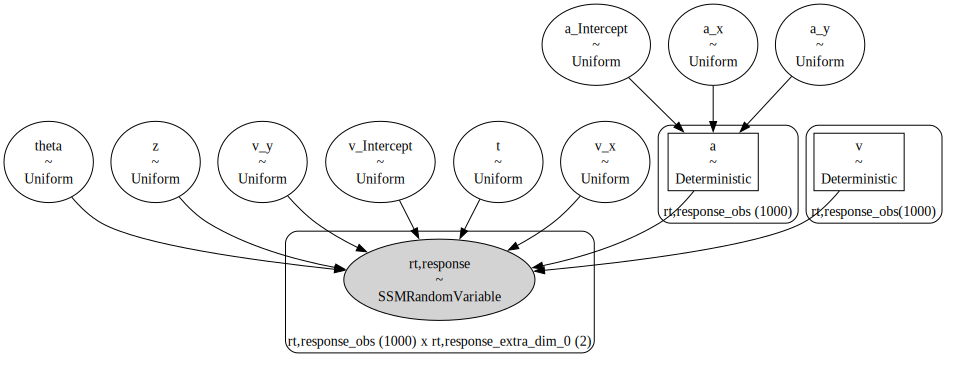

In [64]:
hssm_reg_v_a_angle.graph()

In [65]:
infer_data_reg_v_a = hssm_reg_v_a_angle.sample(
    sampler="nuts_numpyro", chains=2, cores=1, draws=1000, tune=1000
)

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/numpyro/util.py:227: DeprecationWarning: The host_callback APIs are deprecated as of March 20, 2024. The functionality is subsumed by the new JAX external callbacks. See https://jax.readthedocs.io/en/latest/notebooks/external_callbacks.html.
  lambda _: host_callback.id_tap(
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/ipykernel/iostream.py:154: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x2988b0e50>
  self._event_pipes[threadi

In [66]:
az.summary(infer_data_reg_v_a, var_names = ['~a', '~v']) # , var_names=["~rt,response_a"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a_Intercept  1.474  0.044   1.391    1.554      0.001    0.001    1101.0   
a_x          0.050  0.041  -0.026    0.126      0.001    0.001    1569.0   
a_y          0.003  0.037  -0.066    0.070      0.001    0.001    2052.0   
t            0.131  0.024   0.087    0.178      0.001    0.000    1338.0   
theta        0.009  0.018  -0.024    0.044      0.001    0.000    1138.0   
v_Intercept  0.307  0.033   0.244    0.368      0.001    0.001    1530.0   
v_x          0.903  0.047   0.823    0.994      0.001    0.001    1181.0   
v_y          0.265  0.045   0.181    0.349      0.001    0.001    2073.0   
z            0.507  0.013   0.485    0.532      0.000    0.000    1469.0   

             ess_tail  r_hat  
a_Intercept    1209.0    1.0  
a_x            1419.0    1.0  
a_y            1461.0    1.0  
t              1273.0    1.0  
theta           940.0    1.0  
v_Intercept    1276.0    1.0  
v_x             663.0    1.0  
v_y            1407.0    1.0  
z              1275.0    1.0

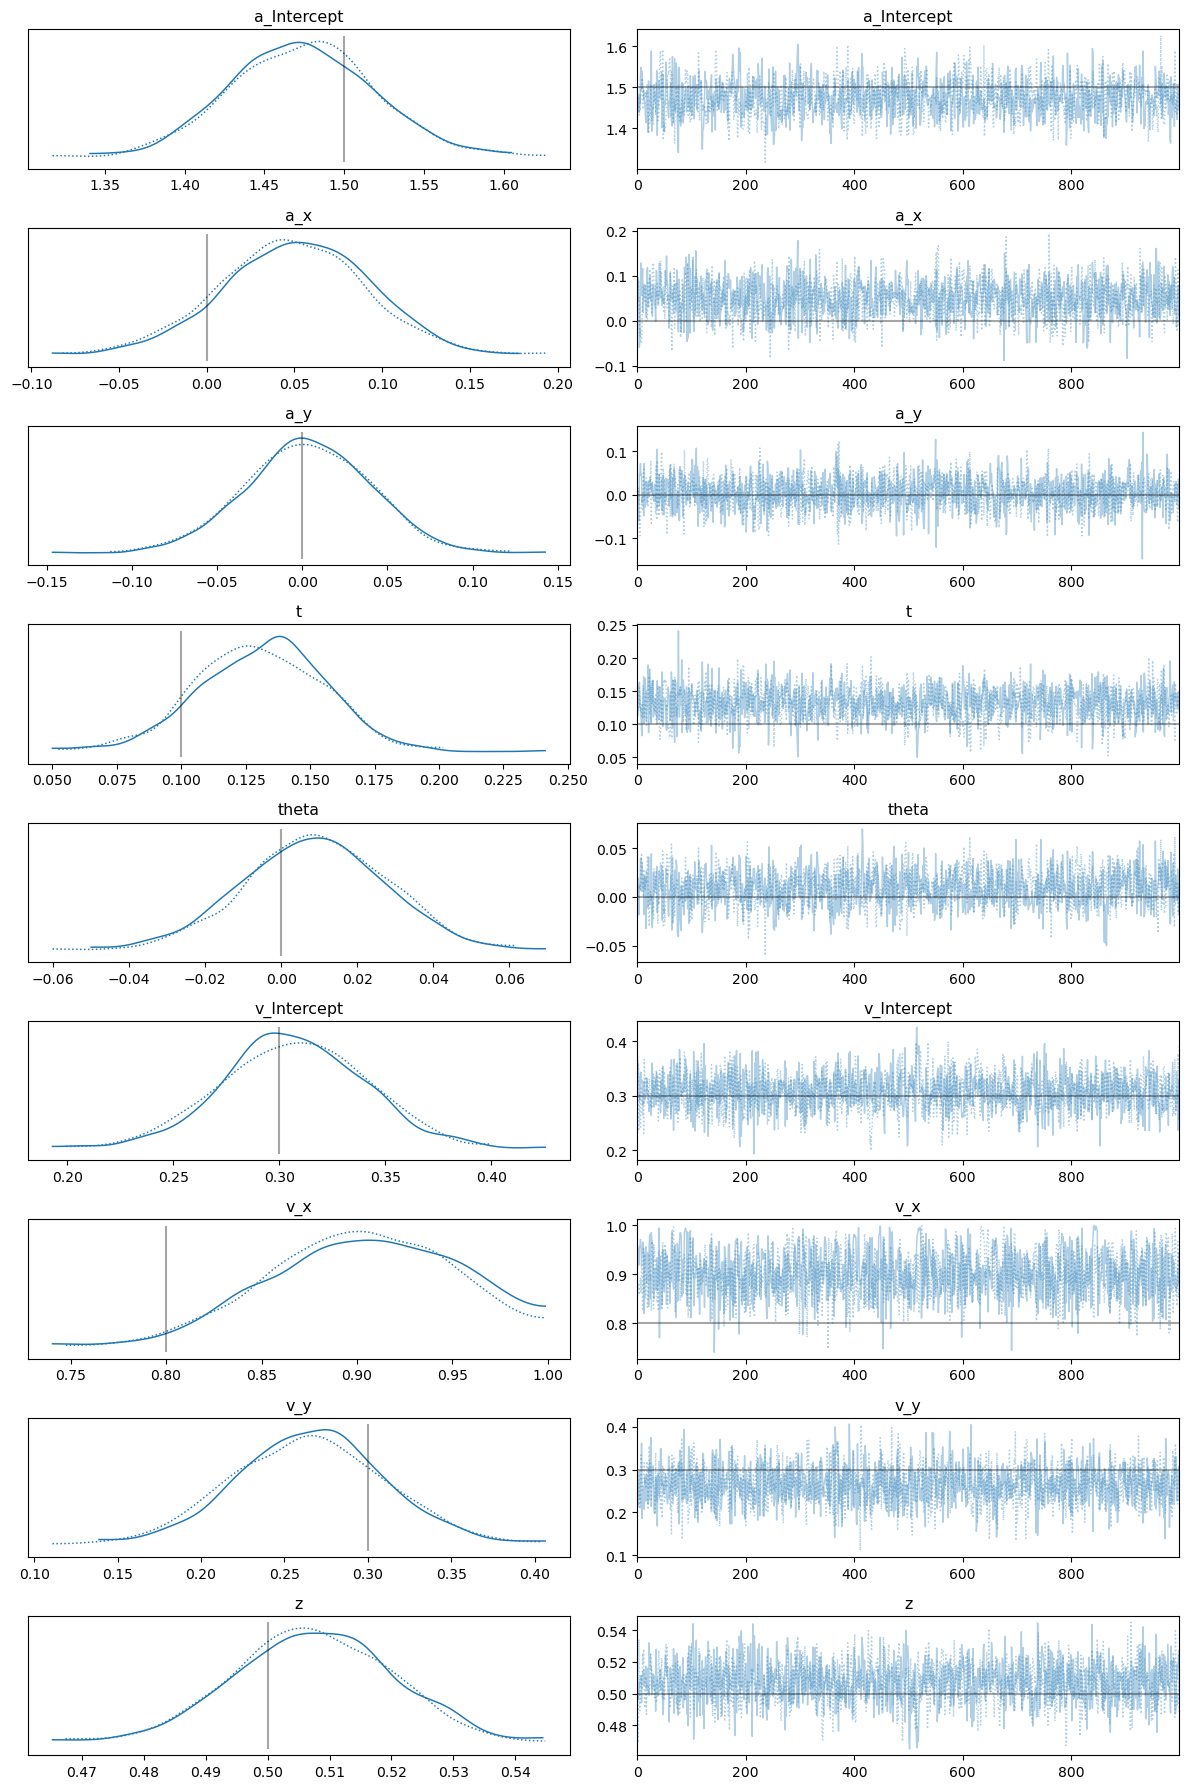

In [67]:
az.plot_trace(hssm_reg_v_a_angle.traces, 
              var_names = ['~v', '~a'],
              lines = [('a_Intercept', {}, a_reg_v), 
                       ('v_Intercept', {}, v_intercept), 
                       ('a_x', {}, 0.0),
                       ('a_y', {}, 0.0),
                       ('v_x', {}, v_x),
                       ('v_y', {}, v_y),
                       ('t', {}, t_reg_v),
                       ('z', {}, z_reg_v),
                       ('theta', {}, 0)])
plt.tight_layout()

We successfully recover our regression betas for `a`! Moreover, no warning signs concerning our chains.

### Case 4: Categorical covariates

In [ ]:
# Set up trial by trial parameters
v_intercept = 0.3
x = np.random.uniform(-1, 1, size=1000)
v_x = 0.8
y = np.random.uniform(-1, 1, size=1000)
v_y = 0.3
v_reg_v = v_intercept + (v_x * x) + (v_y * y)

# rest
a_reg_v = 1.5
z_reg_v = 0.5
t_reg_v = 0.1

# base dataset
dataset_reg_v = hssm.simulate_data(model = 'ddm',
                                   theta = dict(v = v_reg_v,
                                                a = a_reg_v,
                                                z = z_reg_v,
                                                t = t_reg_v),
                                   size = 1)

# Adding covariates into the datsaframe
dataset_reg_v['x'] = x
dataset_reg_v['y'] = y

## Hierarchical Inference

Let's try to fit a hierarchical model now. We will simulate a dataset with $15$ participants, with $200$ observations / trials for each participant. 

We define a group mean `mean_v` and a group standard deviation `sd_v` for the intercept parameter of the regression on `v`, which we sample from a corresponding normal distribution for each subject.

### Simulate Data

In [68]:
# Make some hierarchical data

n_subjects = 15  # number of subjects
n_trials = 200  # number of trials per subject

sd_v = 0.5  # sd for v-intercept
mean_v = 0.5  # mean for v-intercept

data_list = []
for i in range(n_subjects):
    # Make parameters for subject i
    v_intercept_hier = np.random.normal(mean_v, sd_v, size=1)
    x = np.random.uniform(-1, 1, size=n_trials)
    v_x_hier = 0.8
    y = np.random.uniform(-1, 1, size=n_trials)
    v_y_hier = 0.3
    v_hier = v_intercept_hier + (v_x_hier * x) + (v_y_hier * y)

    a_hier = 1.5
    t_hier = 0.5
    z_hier = 0.5

    # true_values = np.column_stack(
    #     [v, np.repeat([[1.5, 0.5, 0.5, 0.0]], axis=0, repeats=n_trials)]
    # )

    data_tmp = hssm.simulate_data(model = "ddm", 
                                  theta = dict(v = v_hier,
                                                     a = a_hier,
                                                     z = z_hier,
                                                     t = t_hier),
                                  size = 1)
    data_tmp['subject'] = i
    data_tmp['x'] = x
    data_tmp['y'] = y

    data_list.append(data_tmp)
    
# Make single dataframe out of subject-wise datasets
dataset_reg_v_hier = pd.concat(data_list)
dataset_reg_v_hier

rt  response  subject         x         y
0    2.487689       1.0        0  0.240273 -0.528572
1    0.956160       1.0        0  0.511989  0.975287
2    2.923388       1.0        0 -0.858330  0.202023
3    1.870323       1.0        0 -0.395769 -0.177885
4    1.932789      -1.0        0 -0.612474  0.637020
..        ...       ...      ...       ...       ...
195  1.983936       1.0       14  0.181324  0.456961
196  1.166552       1.0       14  0.878781 -0.970548
197  2.810246       1.0       14 -0.264702 -0.975855
198  2.089309       1.0       14  0.912618 -0.102567
199  1.605393      -1.0       14  0.204114 -0.166559

[3000 rows x 5 columns]

We can now define our `HSSM` model. 

We specify the regression as `v ~ 1 + (1|subject) + x + y`. 

`(1|subject)` tells the model to create a *subject-wise* offset for the intercept parameter. The rest of the regression $\beta$'s is fit globally. 

As an **R** user you may recognize this syntax from the [lmer](https://www.rdocumentation.org/packages/lme4/versions/1.1-33/topics/lmer) package. 

Our [Bambi](https://bambinos.github.io/bambi/) backend is essentially a Bayesian version of [lmer](https://www.rdocumentation.org/packages/lme4/versions/1.1-33/topics/lmer), quite like the [BRMS](https://cran.r-project.org/web/packages/brms/index.html) package in **R**, which operates on top of [STAN](https://mc-stan.org/). 

As a previous [HDDM](https://hddm.readthedocs.io/en/latest/) user, you may recognize that now proper mixed-effect models are viable! 

You should be able to handle between and within subject effects naturally now!


In [69]:
model_reg_v_angle_hier = hssm.HSSM(
    data=dataset_reg_v_hier,
    model="angle",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject) + x + y",
            "link": "identity",
        }
    ],
)

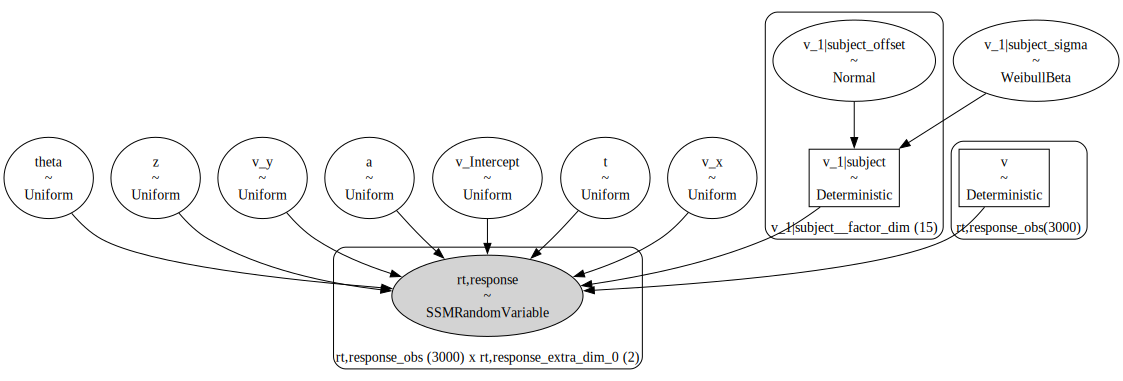

In [70]:
model_reg_v_angle_hier.graph()

In [71]:
jax.config.update("jax_enable_x64", False)
model_reg_v_angle_hier.sample(
    sampler="nuts_numpyro", chains=2, cores=1, draws=1000, tune=1000
)

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_met

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/numpyro/util.py:227: DeprecationWarning: The host_callback APIs are deprecated as of March 20, 2024. The functionality is subsumed by the new JAX external callbacks. See https://jax.readthedocs.io/en/latest/notebooks/external_callbacks.html.
  lambda _: host_callback.id_tap(
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/ipykernel/iostream.py:154: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x2afbaf4d0>
  self._event_pipes[threadi

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Let's look at the posteriors!

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

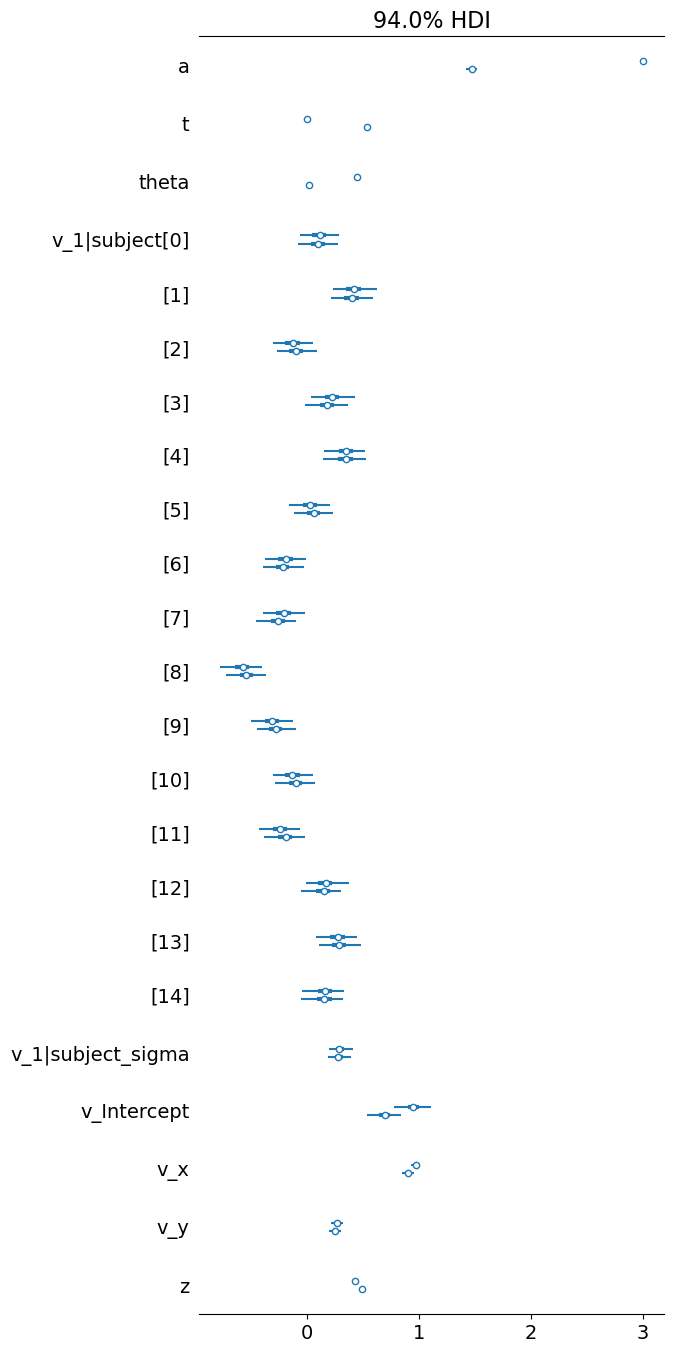

In [72]:
az.plot_forest(model_reg_v_angle_hier.traces, var_names = ['~v'], combined=False)

## Model Comparison

Fitting single models is all well and good. We are however, often interested in comparing how well a few different models account for the same data. 

Through [ArviZ](https://python.arviz.org/en/stable/index.html), we have out of the box access to modern Bayesian Model Comparison. We will keep it simple here, just to illustrate the basic idea. 

### Scenario

The following scenario is explored. 

First we generate data from a `ddm` model with fixed parameters, specifically we set the `a` parameter to $1.5$. 

We then define two `HSSM` models:

1. A model which allows fitting all but the `a` parameter, which is fixed to $1.0$ (wrong)
2. A model which allows fitting all but the `a` parameter, which is fixed to $1.5$ (correct)

We then use the [ArviZ](https://python.arviz.org/en/stable/index.html)'s `compare()` function, to perform model comparison via `elpd_loo`. 

### Data Simulation

In [73]:
# Parameters
v_mod_comp = 0.5
a_mod_comp = 1.5
z_mod_comp = 0.5
t_mod_comp = 0.2

# Simulation
dataset_model_comp = hssm.simulate_data(model = "ddm",
                                        theta = dict(v = v_mod_comp,
                                                     a = a_mod_comp,
                                                     z = z_mod_comp,
                                                     t = t_mod_comp),
                                        size = 500)

print(dataset_model_comp)

           rt  response
0    2.237381       1.0
1    1.365178      -1.0
2    2.740572       1.0
3    1.736053       1.0
4    0.724717       1.0
..        ...       ...
495  1.333326       1.0
496  2.123171       1.0
497  1.672813       1.0
498  2.236918       1.0
499  3.285769      -1.0

[500 rows x 2 columns]


### Defining the Models

In [74]:
# 'wrong' model
model_model_comp_1 = hssm.HSSM(
    data=dataset_model_comp,
    model="angle",
    a=1.0,
)

In [75]:
# 'correct' model
model_model_comp_2 = hssm.HSSM(
    data=dataset_model_comp,
    model="angle",
    a=1.5,
)

In [76]:
# 'wrong' model ddm
model_model_comp_3 = hssm.HSSM(
    data=dataset_model_comp,
    model="ddm",
    a=1.0,
)

In [77]:
infer_data_model_comp_1 = model_model_comp_1.sample(
    sampler="nuts_numpyro",
    cores=1,
    chains=2,
    draws=1000,
    tune=1000,
    idata_kwargs=dict(
        log_likelihood=True
    ),  # model comparison metrics usually need this!
)

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/numpyro/util.py:227: DeprecationWarning: The host_callback APIs are deprecated as of March 20, 2024. The functionality is subsumed by the new JAX external callbacks. See https://jax.readthedocs.io/en/latest/notebooks/external_callbacks.html.
  lambda _: host_callback.id_tap(
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/ipykernel/iostream.py:154: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x2aaccbe70>
  self._event_pipes[threadi

In [78]:
infer_data_model_comp_2 = model_model_comp_2.sample(
    sampler="nuts_numpyro",
    cores=1,
    chains=2,
    draws=1000,
    tune=1000,
    idata_kwargs=dict(
        log_likelihood=True
    ),  # model comparison metrics usually need this!
)

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/numpyro/util.py:227: DeprecationWarning: The host_callback APIs are deprecated as of March 20, 2024. The functionality is subsumed by the new JAX external callbacks. See https://jax.readthedocs.io/en/latest/notebooks/external_callbacks.html.
  lambda _: host_callback.id_tap(
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/ipykernel/iostream.py:154: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x2f29b5be0>
  self._event_pipes[threadi

In [79]:
infer_data_model_comp_3 = model_model_comp_3.sample(
    sampler="nuts_numpyro",
    cores=1,
    chains=2,
    draws=1000,
    tune=1000,
    idata_kwargs=dict(
        log_likelihood=True
    ),  # model comparison metrics usually need this!
)

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_met

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/numpyro/util.py:227: DeprecationWarning: The host_callback APIs are deprecated as of March 20, 2024. The functionality is subsumed by the new JAX external callbacks. See https://jax.readthedocs.io/en/latest/notebooks/external_callbacks.html.
  lambda _: host_callback.id_tap(
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/ipykernel/iostream.py:154: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x2982dcd00>
  self._event_pipes[threadi

### Compare

In [80]:
compare_data = az.compare(
    {
        "a_fixed_1(wrong)": model_model_comp_1.traces,
        "a_fixed_1.5(correct)": model_model_comp_2.traces,
        "a_fixed_1_ddm(wrong)": model_model_comp_3.traces,
    }
)

compare_data

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/Users/afengler/mini

rank     elpd_loo     p_loo   elpd_diff    weight  \
a_fixed_1.5(correct)     0 -1028.859722  5.040529    0.000000  0.890955   
a_fixed_1(wrong)         1 -1069.085978  3.713685   40.226255  0.109045   
a_fixed_1_ddm(wrong)     2 -1130.435150  1.867999  101.575428  0.000000   

                             se        dse  warning scale  
a_fixed_1.5(correct)  24.495798   0.000000     True   log  
a_fixed_1(wrong)      29.518063  10.186191     True   log  
a_fixed_1_ddm(wrong)  35.207903  15.206123     True   log

Notice how the posterior weight on the `correct` model is close to (or equal to ) $1$ here. 
In other words model comparison points us to the correct model with 
a very high degree of certainty here!


We can also use the `.plot_compare()` function to illustrate the model comparison visually.

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

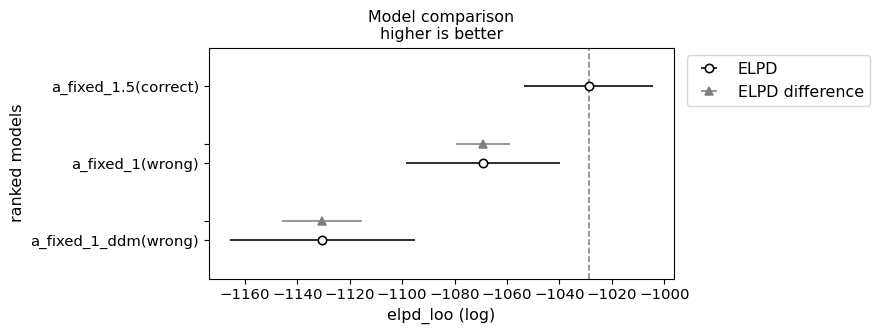

In [81]:
az.plot_compare(compare_data)

Using the forest plot we can take a look at what goes wrong for the "wrong" model. 

To make up for the mistplaced setting of the `a` parameter, the posterior seems to compensate by
mis-estimating the other parameters.

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

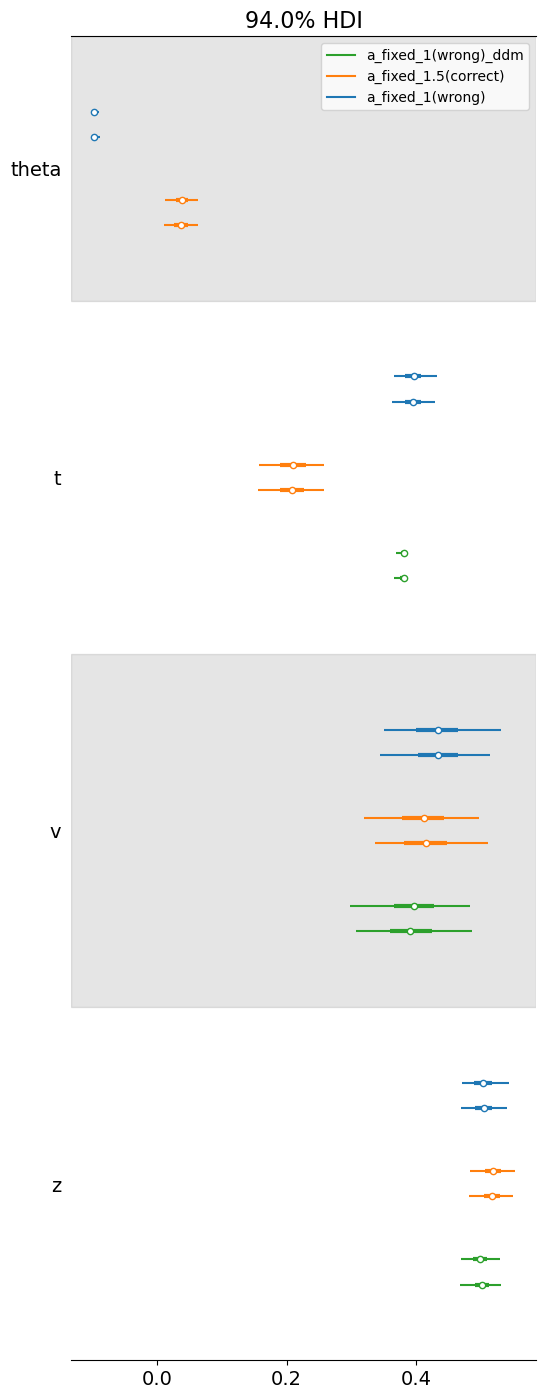

In [82]:
az.plot_forest([model_model_comp_1.traces, 
                model_model_comp_2.traces, 
                model_model_comp_3.traces], model_names = ["a_fixed_1(wrong)", 
                                                           "a_fixed_1.5(correct)",
                                                           "a_fixed_1(wrong)_ddm"])

## Closer look!

<center> <img src="images/pytensor_jax.png" height="400" width="400"> </center>

We have seen a few examples of HSSM models at this point. Add a model via a string, maybe toy a bit with with the priors and set regression functions for a given parameter. Turn it hierarchical...  Here we begin to peak a bit under the hood. 

After all, we want to encourage you to contribute models to the package yourself. 

Let's remind ourself of the `model_config` dictionaries that define model properties for us. Again let's start with the DDM.

In [83]:
hssm.config.default_model_config["ddm"].keys()

dict_keys(['response', 'list_params', 'description', 'likelihoods'])

The dictionary has a few high level keys. 

1. `response`

2. `list_params`

3. `description`

4. `likelihoods`


Let us take a look at the available `likelihoods`:

In [84]:
hssm.config.default_model_config["ddm"]["likelihoods"]

{'analytical': {'loglik': <function hssm.likelihoods.analytical.logp_ddm(data: numpy.ndarray, v: float, a: float, z: float, t: float, err: float = 1e-15, k_terms: int = 20, epsilon: float = 1e-15) -> numpy.ndarray>,
  'backend': None,
  'bounds': {'v': (-inf, inf),
   'a': (0.0, inf),
   'z': (0.0, 1.0),
   't': (0.0, inf)},
  'default_priors': {'t': {'name': 'HalfNormal', 'sigma': 2.0}},
  'extra_fields': None},
 'approx_differentiable': {'loglik': 'ddm.onnx',
  'backend': 'jax',
  'default_priors': {'t': {'name': 'HalfNormal', 'sigma': 2.0}},
  'bounds': {'v': (-3.0, 3.0),
   'a': (0.3, 2.5),
   'z': (0.0, 1.0),
   't': (0.0, 2.0)},
  'extra_fields': None},
 'blackbox': {'loglik': <function hssm.likelihoods.blackbox.hddm_to_hssm.<locals>.outer(data: numpy.ndarray, *args, **kwargs)>,
  'backend': None,
  'bounds': {'v': (-inf, inf),
   'a': (0.0, inf),
   'z': (0.0, 1.0),
   't': (0.0, inf)},
  'default_priors': {'t': {'name': 'HalfNormal', 'sigma': 2.0}},
  'extra_fields': None}}

For the DDM we have available all three types of likelihoods that HSSM deals with:

1. `analytical`
2. `approx_differentiable`
3. `blackbox`

Let's expand the dictionary contents more:

In [85]:
hssm.config.default_model_config["ddm"]["likelihoods"]["analytical"]

{'loglik': <function hssm.likelihoods.analytical.logp_ddm(data: numpy.ndarray, v: float, a: float, z: float, t: float, err: float = 1e-15, k_terms: int = 20, epsilon: float = 1e-15) -> numpy.ndarray>,
 'backend': None,
 'bounds': {'v': (-inf, inf),
  'a': (0.0, inf),
  'z': (0.0, 1.0),
  't': (0.0, inf)},
 'default_priors': {'t': {'name': 'HalfNormal', 'sigma': 2.0}},
 'extra_fields': None}

We see three properties (key) in this dictionary, of which two are essential:

- The `loglik` field, which points to the likelihood function
- The `backend` field, which can be either `None` (defaulting to pytensor for `analytical` likelihoods), `jax` or `pytensor`
- The `bounds` field, which specifies bounds on a subset of the model parameters
- The `default_priors` field, which specifies parameter wise priors

If you provide `bounds` for a parameter, but no `default_priors`, a *Uniform* prior that respects the specified bounds will be applied. 

Next, let's look at the `approx_differentiable` part. 
The likelihood in this part is based on a [LAN]() which was available in [HDDM]() through the [LAN extension](). 

In [86]:
hssm.config.default_model_config["ddm"]["likelihoods"]["approx_differentiable"]

{'loglik': 'ddm.onnx',
 'backend': 'jax',
 'default_priors': {'t': {'name': 'HalfNormal', 'sigma': 2.0}},
 'bounds': {'v': (-3.0, 3.0),
  'a': (0.3, 2.5),
  'z': (0.0, 1.0),
  't': (0.0, 2.0)},
 'extra_fields': None}

We see that the `loglik` field is now a string that points to a `.onnx` file. 
[Onnx](https://onnx.ai/) is a meta framework for Neural Network specification, that allows translation between deep learning Frameworks. This is the preferred format for the neural networks we store in our model reservoir on [HuggingFace](https://huggingface.co/).

Moreover notice that we now have a `backend` field. We allow for two primary backends in the `approx_differentiable` field. 

1. `pytensor`
2. `jax` 

The `jax` backend assumes that your likelihood is described as a jax function, the `pytensor` backend assumes that your likelihood is described as a `pytensor` function. Ok not that surprising...

We won't dwell on this here, however the key idea is to provide users with a large degree of flexibility in describing their likelihood functions and moreover to allow targeted optimization towards MCMC sampler types that [PyMC]() allows us to access.

You can find a [dedicated tutorial](https://lnccbrown.github.io/HSSM/tutorial_likelihoods/#3-kinds-of-likelihoods) in the documentation, which describes the different likelihoods in much more detail. 

Instead, let's take a quick look at how these newfound insights can be used for custom model definition. 

In [87]:
hssm_alternative_model = hssm.HSSM(
    data=dataset,
    model="ddm",
    loglik_kind="approx_differentiable",
)

In [88]:
hssm_alternative_model.loglik_kind

'approx_differentiable'

In this case we actually built the model class with an `approx_differentiable` LAN likelihood, instead of the default `analytical` likelihood we used in the beginning of the tutorial. The assumed generative model remains the `ddm` however!

In [89]:
hssm_alternative_model.sample(
    sampler="nuts_numpyro",
    cores=1,
    chains=2,
    draws=1000,
    tune=1000,
    idata_kwargs=dict(
        log_likelihood=False
    ),  # model comparison metrics usually need this!
)

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_met

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/numpyro/util.py:227: DeprecationWarning: The host_callback APIs are deprecated as of March 20, 2024. The functionality is subsumed by the new JAX external callbacks. See https://jax.readthedocs.io/en/latest/notebooks/external_callbacks.html.
  lambda _: host_callback.id_tap(
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/site-packages/ipykernel/iostream.py:154: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x2f2e36900>
  self._event_pipes[threadi

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

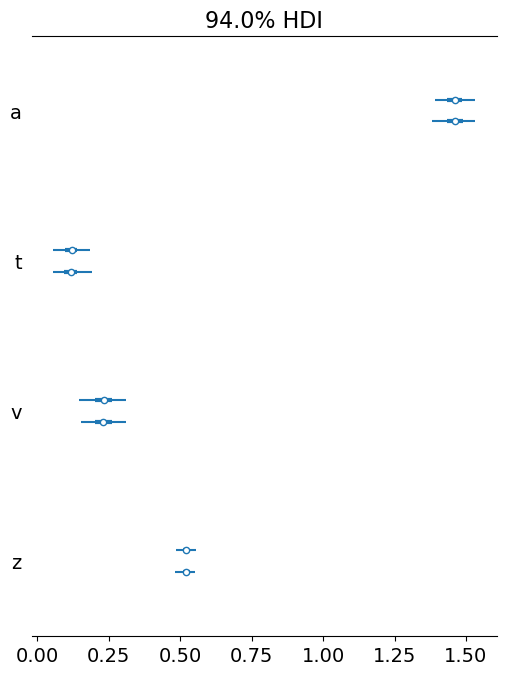

In [90]:
az.plot_forest(hssm_alternative_model.traces)

We can take this further and specify a completely custom likelihood. See the [dedicated tutorial](https://lnccbrown.github.io/HSSM/tutorial_likelihoods/#using-custom-likelihoods) for more examples!

We will see one specific example below to illustrate another type of likelihood function we have available for model building in HSSM, the *Blackbox* likelihood. 

## 'Blackbox' Likelihoods

<center> <img src="images/blackbox.png" height="400" width="400"> </center>

### What is a **Blackbox Likelihood Function**?

A *Blackbox Likelihood Function* is essentially any Python `callable` (function) that provides trial by trial likelihoods for your model of interest. What kind of computations are performed in this Python function is completely arbitrary. 

E.g. you could built a function that performs forward simulation from you model, constructs are kernel-density estimate for the resulting likelihood functions and evaluates your datapoints on this ad-hoc generated approximate likelihood.

What I just described is a once state-of-the-art method of performing simulation based inference on Sequential Sampling models, a precursor to LANs if you will.

We will do something simpler to keep it short and sweet, but really... the possibilities are endless!

<br> </br>
<center><img src="https://media.giphy.com/media/juq2OXONntuHfLc4Tn/giphy.gif" style="margin:auto" height="300" width="300"/></center>
<br> </br>


### Simulating simple dataset from the DDM

As always, let's begin by generating some simple dataset. 

In [91]:
# Set parameters
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.5]

# Simulate
hssm.simulate_data(model="ddm",
                   theta=dict(v=v_true,
                              a=a_true,
                              z=z_true,
                              t=t_true),
                   size = 1000)
                              

dataset

rt  response
0    4.088902       1.0
1    3.388339       1.0
2    1.225302       1.0
3    0.625104       1.0
4    4.008369       1.0
..        ...       ...
495  0.978089      -1.0
496  0.626664       1.0
497  5.255781      -1.0
498  0.778616      -1.0
499  2.818933       1.0

[500 rows x 2 columns]

### Define the likelihood

Now the fun part... we simply define a Python function `my_blackbox_loglik` which takes in our `data` as well as a bunch of model parameters (in our case the familiar `v`,`a`, `z`, `t` from the DDM).

The function then does some arbitrary computation inside (in our case e.g. we pass the data and parameters to the DDM log-likelihood from our predecessor package HDDM).

The important part is that inside `my_blackbox_loglik` anything can happen. We happen to call a little custom function that defines the likelihood of a DDM.

**Fun fact:**
It is de-facto the likelihood which is called by [HDDM](https://hddm.readthedocs.io/en/latest/).

In [92]:
def my_blackbox_loglik(data, v, a, z, t, err=1e-8):
    data = data[:, 0] * data[:, 1]
    # Our function expects inputs as float64, but they are not guaranteed to
    # come in as such --> we type convert
    return hddm_wfpt.wfpt.pdf_array(
        np.float64(data),
        np.float64(v),
        0,
        np.float64(2 * a),
        np.float64(z),
        0,
        np.float64(t),
        0,
        err,
        1,
    )

### Define HSSM class with our Blackbox Likelihood

We can now define our HSSM model class as usual, however passing our `my_blackbox_loglik()` function to the `loglik` argument, and passing as `loglik_kind = blackbox`. 

The rest of the model config is as usual. Here we can reuse our `ddm` model config, and simply specify bounds on the parameters (e.g. your Blackbox Likelihood might be trustworthy only on a restricted parameters space). 

In [93]:
blackbox_model = hssm.HSSM(
    data=dataset,
    model="ddm",
    loglik=my_blackbox_loglik,
    loglik_kind="blackbox",
    model_config={
        "bounds": {
            "v": (-10.0, 10.0),
            "a": (0.5, 5.0),
            "z": (0.0, 1.0),
        }
    },
    t=bmb.Prior("Uniform", lower=0.0, upper=2.0, initval=0.1),
)

In [94]:
sample = blackbox_model.sample()

Sampling 4 chains, 0 divergences ━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━━━━━━━━━  39% 0:00:05 / 0:00:03

**NOTE**:

Since *Blackbox likelihood functions* are assumed to not be differentiable, our default sampler for such likelihood functions is a `Slice` sampler. HSSM allows you to choose any other suitable sampler from the PyMC package instead. A bunch of options are available for gradient-free samplers.

### Results

In [95]:
az.summary(sample)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a  1.484  0.036   1.420    1.554      0.001    0.001    1950.0    2596.0   
t  0.113  0.031   0.052    0.170      0.001    0.001    1711.0    1953.0   
v  0.232  0.042   0.153    0.309      0.001    0.001    1754.0    2173.0   
z  0.520  0.017   0.487    0.551      0.000    0.000    1501.0    2493.0   

   r_hat  
a    1.0  
t    1.0  
v    1.0  
z    1.0

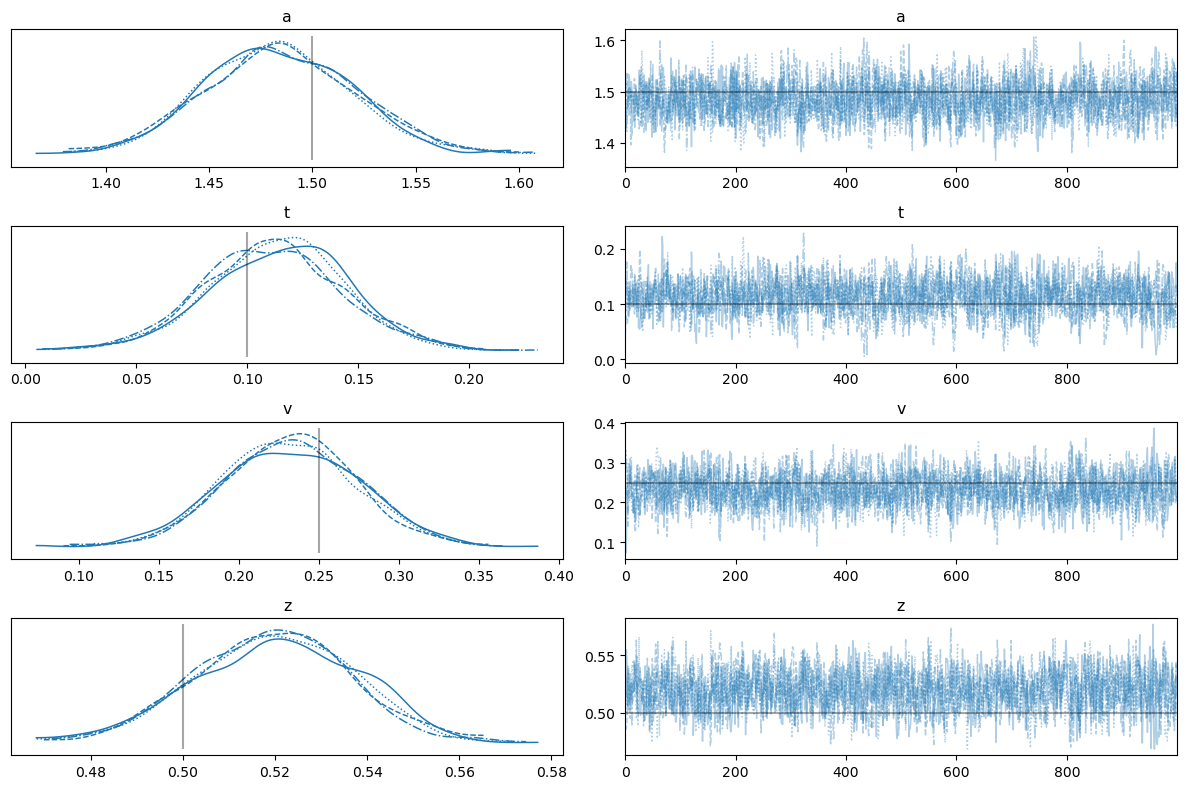

In [96]:
az.plot_trace(sample, lines = [('a', {}, 1.5),
                               ('v', {}, 0.25),
                               ('z', {}, 0.5),
                               ('t', {}, 0.1),])
plt.tight_layout()

## HSSM Random Variables in PyMC

We covered a lot of ground in this tutorial so far. You are now a sophisticated HSSM user. 

It is therefore time to reveal a secret. We can actuallly peel back one more layer...
<br> </br>
<center><img src="https://media.giphy.com/media/3o6EhKIVvdhTkvjT8s/giphy.gif" style="margin:auto" height="300" width="300"/></center>
<br> </br>

Instead of letting HSSM help you build the entire model, we can instead use HSSM to construct valid [PyMC](https://www.pymc.io/welcome.html) distributions and then proceed to build a custom PyMC model by ourselves...
<br> </br>
<center><img src="https://media.giphy.com/media/3pDxFfu5yZblPUVnWY/giphy.gif" style="margin:auto" height="300" width="300"/></center>
<br> </br>

We will illustrate the simplest example below. It sets a pattern that can be exploited for much more complicated modeling exercises, which importantly go far beyond what our basic HSSM class may facilitate for you! 

See the [dedicated tutorial](https://lnccbrown.github.io/HSSM/notebooks/pymc/) in the [documentation](https://lnccbrown.github.io/HSSM/) if you are interested.

Let's start by importing a few convenience functions:

In [97]:
# from hssm.distribution_utils import (
#     make_distribution,  # A general function for making Distribution classes
#     make_distribution_from_onnx,  # Makes Distribution classes from onnx files
#     make_distribution_from_blackbox,  # Makes Distribution classes from callables
# )

# pm.Distributions that represents the top-level distribution for
# DDM models (the Wiener First-Passage Time distribution)
from hssm.likelihoods import logp_ddm_sdv, DDM

### Simulate some data

In [98]:
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.5]

# Simulate
dataset_pymc= hssm.simulate_data(model="ddm",
                                 theta=dict(v=v_true, 
                                            a=a_true,
                                            z=z_true,
                                            t=t_true),
                                 size=1000)

dataset_pymc

rt  response
0    1.178703       1.0
1    2.255696       1.0
2    3.386907       1.0
3    1.634623       1.0
4    1.944810       1.0
..        ...       ...
995  1.542038       1.0
996  1.419097       1.0
997  1.950858       1.0
998  1.751323      -1.0
999  3.631001       1.0

[1000 rows x 2 columns]

### Build a custom PyMC Model

We can now use our custom random variable `DDM` directly in a PyMC model.

In [99]:
import pymc as pm

with pm.Model() as ddm_pymc:
    v = pm.Uniform("v", lower=-10.0, upper=10.0)
    a = pm.HalfNormal("a", sigma=2.0)
    z = pm.Uniform("z", lower=0.01, upper=0.99)
    t = pm.Uniform("t", lower=0.0, upper=0.6, initval=0.1)

    ddm = DDM("DDM", v=v, a=a, z=z, t=t, observed=dataset_pymc[['rt', 'response']].values)

Let's check the model graph:

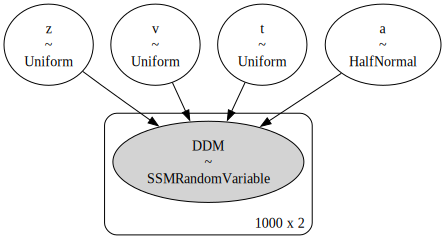

In [100]:
pm.model_to_graphviz(model=ddm_pymc)

Looks remarkably close to our HSSM version!

We can use PyMC directly to sample and finally return to ArviZ for some plotting!

In [101]:
with ddm_pymc:
    ddm_pymc_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [v, a, z, t]
/Users/afengler/miniconda3/envs/hssm_pymc514/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Output()

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

Sampling 4 chains for 1_000 tune and 1_000 dra

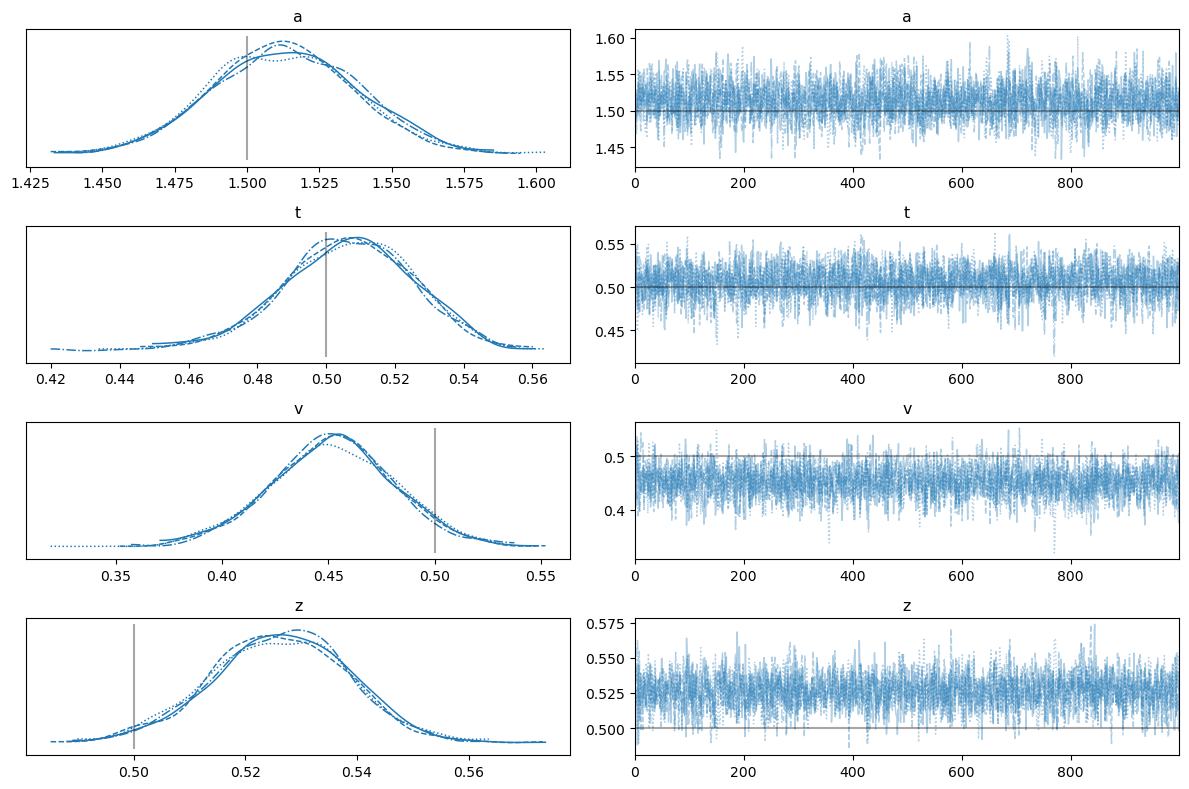

In [102]:
az.plot_trace(ddm_pymc_trace, lines = [('v', {}, v_true),
                                       ('a', {}, a_true),
                                       ('t', {}, t_true),
                                       ('z', {}, z_true)])

plt.tight_layout()

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

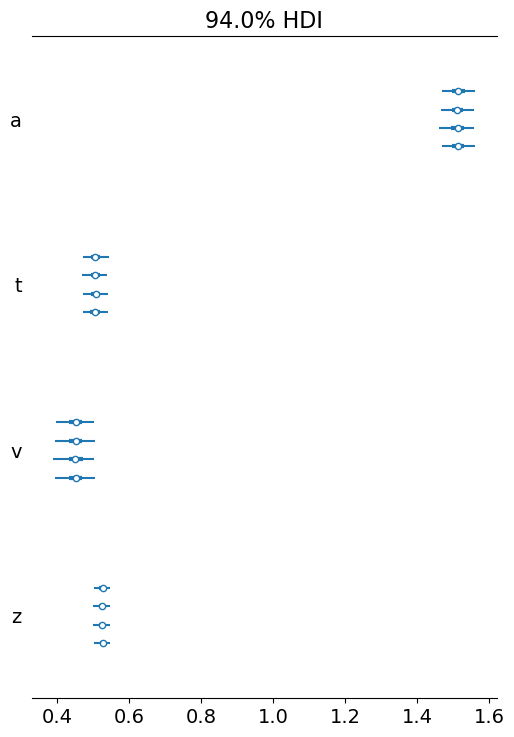

In [103]:
az.plot_forest(ddm_pymc_trace)

### Regression via PyMC

In [104]:
# AF:TODO 

All layers peeled back, the only limit in your modeling endeavors becomes the limit of the PyMC universe!

<br> </br>

<center><img src="https://media.giphy.com/media/4ydWTcMBjimLbT1CHi/giphy.gif" style="margin:auto" height="300" width="300"/></center>


<center> Enjoy the exploration! </center>

# End